In [ ]:
import natsort
import numpy as np
import pandas as pd
import param
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import re
import traceback
import panel as pn
pn.extension("plotly")
import io
from io import BytesIO
from io import StringIO
from bokeh.models.widgets.tables import NumberFormatter
from sklearn.decomposition import PCA
import json
import ast
import statistics 
import matplotlib.pyplot as plt
import matplotlib_venn as venn
from matplotlib_venn import venn2, venn3, venn3_circles
from PIL import Image
from upsetplot import from_memberships
from upsetplot import plot
pn.extension()

In [215]:
exec(open("class.py").read())

i_file = pn.widgets.FileInput(name="Upload file")

loading_status = pn.Row()
idle = pn.indicators.LoadingSpinner(value=False, width=100, height=100, color="primary")
loading = pn.indicators.LoadingSpinner(value=True, width=100, height=100, color="primary")

button_analysis = pn.widgets.Button(name="Analyse clusters", width=50)
button_SVM_analysis = pn.widgets.Button(name="Analyse misclassification matrix", width=50)

i_logOR01_selection = pn.widgets.Select(options=["0/1 normalized data", "log transformed data"], name="Select type of data for download", width=300)

i_acquisition = pn.widgets.Select(options=["LFQ6 - Spectronaut", "LFQ5 - Spectronaut", "LFQ6 - MQ", "LFQ5 - MQ",  "SILAC - MQ"], name="Acquisition", width=300)
i_organism = pn.widgets.Select(options=list(SpatialDataSet.markerproteins_set.keys()), name="Organism", width=300) #

i_SVM_table = pn.widgets.input.TextAreaInput(name="Misclassification matrix from Perseus", placeholder="Copy matrix here...")

i_comment = pn.widgets.input.TextAreaInput(name="Additional Comments", placeholder="Write any kind of information assoiciated with this dataset here...")

i_clusterwidget = pn.widgets.Select(options=["Proteasome", "Lysosome"], name="Cluster of interest", width=300)
i_mapwidget = pn.widgets.Select(options=["Map1", "Map2"], name="Map of interest", width=300)

i_collapse_maps_PCA = pn.widgets.Checkbox(value=False, name="Collapse maps")

cache_uploaded = pn.widgets.Checkbox(value=False)
cache_uploaded_SVM = pn.widgets.Checkbox(value=False)

cache_run = pn.widgets.Checkbox(value=False)

analysis_status = pn.Pane("No analysis run yet", width=1000)
analysis_status_SVM = pn.Pane("No SVM analysis run yet", width=1000)
filereading_status = pn.Pane("No data import yet", width=1000)

i_expname = pn.widgets.TextInput(name="Experiment Name", placeholder="Enter your experiment name here here...")

i_consecutiveLFQi = pn.widgets.IntSlider(name="Consecutive LFQ intensities", start=1, end=10, step=1, value=4)
i_summed_MSMS_counts = pn.widgets.IntSlider(name="Summed MS/MS counts", start=1, end=10, step=1, value=2)

i_RatioHLcount = pn.widgets.IntSlider(name="Ratio H/L Count", start=1, end=10, step=1, value=2)
i_RatioVariability = pn.widgets.IntSlider(name="Ratio H/L variability [%]", start=0, end=100, step=5, value=30)

i_name_pattern = pn.widgets.Select(name="Name pattern",options=["(?P<rep>.*)_(?P<frac>.*)", ".* (?P<cond>.*)_(?P<rep>.*)_(?P<frac>.*)",".* (?P<rep>.*)_(?P<frac>.*)",
                                                                ".* (?P<cond>.*)_(?P<frac>.*)_(?P<rep>.*)", "Custom"])
i_custom_namepattern = pn.widgets.TextInput(name="Customized Name Pattern", placeholder="Enter a string here...e.g.: .* (?P<rep>.*)_(?P<frac>.*)")
regex_pattern = {
    "(?P<rep>.*)_(?P<frac>.*)" : ["Spectronaut MAP1_03K"],
    ".* (?P<rep>.*)_(?P<frac>.*)" : ["MAP1_03K","MAP3_03K"],
    ".* (?P<cond>.*)_(?P<rep>.*)_(?P<frac>.*)" : ["EGF_rep1_06K","EGF_rep3_06K"],
    ".* (?P<cond>.*)_(?P<frac>.*)_(?P<rep>.*)" : ["Control_Mem_1", "Control_Cyt_1"]
    }
i_pattern_examples = pn.widgets.Select(name = "Examples", options=regex_pattern[i_name_pattern.value])

@pn.depends(i_name_pattern.param.value, i_custom_namepattern, i_pattern_examples)
def custimization(name_pattern, custom_namepattern, pattern_examples):
    if name_pattern == "Custom":
        return i_custom_namepattern
    else:
        example_for_name_pattern = regex_pattern[name_pattern]
        i_pattern_examples.options = example_for_name_pattern
        return i_pattern_examples

i_x_vs_yAxis_PCA = {
    "PC1" : ["PC3", "PC2"],
    "PC2" : ["PC1", "PC3"],
    "PC3" : ["PC1", "PC2"],
    }

i_xAxis_PCA = pn.widgets.Select(name="X-Axis", options=["PC1", "PC2","PC3"])
i_yAxis_PCA = pn.widgets.Select(name="Y-Axis", options=i_x_vs_yAxis_PCA[i_xAxis_PCA.value])

i_xAxis_PCA_comp = pn.widgets.Select(name="X-Axis", options=["PC1", "PC2","PC3"])
i_yAxis_PCA_comp = pn.widgets.Select(name="Y-Axis", options=i_x_vs_yAxis_PCA[i_xAxis_PCA_comp.value])

@pn.depends(i_xAxis_PCA_comp.param.value, watch=True)
def custimization_PCA_comp(xAxis_PCA_comp):
    yAxis_PCA_comp = i_x_vs_yAxis_PCA[xAxis_PCA_comp]
    i_yAxis_PCA_comp.options = yAxis_PCA_comp
    #return i_yAxis_PCA_comp

@pn.depends(i_xAxis_PCA.param.value, watch=True)
def custimization_PCA(xAxis_PCA):
    yAxis_PCA = i_x_vs_yAxis_PCA[xAxis_PCA]
    i_yAxis_PCA.options = yAxis_PCA
    #return i_yAxis_PCA

@pn.depends(i_acquisition.param.value, i_consecutiveLFQi, i_summed_MSMS_counts)
def acquisition_response(acquisition, consecutiveLFQi, summed_MSMS_counts):
    if acquisition == "SILAC":
        return pn.Column(pn.Row(i_RatioHLcount, i_RatioVariability), pn.Row(i_name_pattern, custimization))
    else:
        return pn.Column(pn.Row(i_consecutiveLFQi,i_summed_MSMS_counts), pn.Row(i_name_pattern, custimization))

#define widgets that should be disbled after run==True
wdgts = [i_acquisition,i_name_pattern,i_expname, i_pattern_examples, button_analysis, i_expname, i_organism, i_consecutiveLFQi, i_summed_MSMS_counts, 
         i_RatioHLcount, i_RatioVariability, i_comment]            

@pn.depends(i_file.param.value)
def read_file(file):
    if file is None:
        filereading_status = "No file is uploaded"
        cache_uploaded.value = False
        return filereading_status
    else:
        cache_uploaded.value = False
        try:
            df_original = pd.read_csv(BytesIO(file), sep="\t", comment="#", nrows=5, usecols=lambda x: bool(re.match(SpatialDataSet.regex["imported_columns"], x)), low_memory=True)
            cache_uploaded.value = True
            for wdgt in wdgts:
                wdgt.disabled = False

            return pn.Column(pn.Row(pn.widgets.DataFrame(df_original, height=200, width=600, disabled=True)),#i_class.
                             pn.Row(i_expname), 
                             pn.Row(i_organism, i_acquisition), 
                             pn.Row(acquisition_response), 
                             pn.Row(i_comment),
                             pn.Row(button_analysis))

        except Exception: 
            filereading_status = traceback.format_exc()
            cache_uploaded.value = False
            return filereading_status   
        
        
def execution(event):
    if cache_uploaded.value == False:
        analysis_status.object = "Please upload a file first"
    elif i_expname.value == "":
        analysis_status.object = "Please enter an experiment name first"
    else:        
        dashboard_analysis.objects = []
        dashboard_svm.objects = []
        cache_run.value = False
        for wdgt in wdgts:
            wdgt.disabled = True
        #if you did already your comparison, but add another experiment afterwards - without reloading your AnylsedDatasets.json
        #for wdgt in wdgts_comparison:
        #    wdgt.disabled = True
        try:
            
            dashboard_analysis.append(i_clusterwidget)
            dashboard_analysis.append(i_mapwidget)
            dashboard_analysis.append(analysis_tabs)
            i_SVM_table.value = ""
            analysis_status_SVM.object = "Please paste a SVM Matrix first"
            dashboard_svm.append(i_SVM_table)
            dashboard_svm.append(read_SVM_matrix)
            dashboard_svm.append(analysis_status_SVM)
            loading_status.objects = [loading]
            analysis_status.object = "Analysis in progress"
            if i_name_pattern.value == "Custom":
                namePattern = i_custom_namepattern.value
            else:
                namePattern = i_name_pattern.value
            global i_class
            if i_acquisition.value == "SILAC":
                i_class = SpatialDataSet(i_file.filename, i_expname.value, i_acquisition.value, comment=i_comment.value, name_pattern=namePattern, organism=i_organism.value, 
                                         RatioHLcount=i_RatioHLcount.value, RatioVariability=i_RatioVariability.value)
            else:
                i_class = SpatialDataSet(i_file.filename, i_expname.value, i_acquisition.value, comment=i_comment.value, name_pattern=namePattern, organism=i_organism.value,
                                         consecutiveLFQi=i_consecutiveLFQi.value, summed_MSMS_counts=i_summed_MSMS_counts.value)
            analysis_status.object = "Data Reading"
            i_class.data_reading(content=BytesIO(i_file.value))
            analysis_status.object = "Data Processing"
            i_class.processingdf()
            update_object_selector(i_mapwidget, i_clusterwidget)
            i_class.quantity_profiles_proteinGroups()
            analysis_status.object = "PCA"
            i_class.perform_pca()
            i_class.multiple_iterations()
            analysis_status.object = "Calculating Manhattan Distance"
            i_class.distance_calculation()
            analysis_status.object = "Calculating Dynamic Range"
            i_class.dynamic_range()
            analysis_status.object = "Writing Overview Table"
            i_class.results_overview_table()
            analysis_status.object = "Writing Analysed Dataset Dictionary"
            SpatialDataSetComparison.analysed_datasets_dict.update(i_class.analysed_datasets_dict)
            loading_status.objects = [idle]
            analysis_status.object = "Analysis finished! Please open the 'Analysis' tab!"
            cache_run.value = True
            #exc_info = sys.exc_info()
        except:
            for wdgt in wdgts:
                wdgt.disabled = False
            loading_status.objects = [""]
            #The traceback gives no traceback, so out of that there will be still the output: Analysis in progress, although it is not possible. Out of that i removed the traceback
            analysis_status.object = traceback.format_exc()
            cache_run.value = False

button_analysis.on_click(execution)  

def update_object_selector(i_mapwidget, i_clusterwidget):
    i_mapwidget.options = list(i_class.map_names)
    i_clusterwidget.options = list(i_class.markerproteins.keys())
        
@pn.depends(i_SVM_table.param.value)
def read_SVM_matrix(SVM_table):   
    if SVM_table == "":
        SVM_reading_status = "No misclassification matrix is uploaded"
        cache_uploaded_SVM.value = False
    else:
        cache_uploaded_SVM.value = False
        try:
            i_class.df_SVM = pd.read_table(StringIO(SVM_table), sep="\t")
            SVM_reading_status = i_class.df_SVM
            cache_uploaded_SVM.value = True
            return pn.Column(pn.Pane(SVM_reading_status, width=60*SVM_reading_status.shape[1]),
                             pn.Row(button_SVM_analysis))
        except Exception: 
            SVM_reading_status = traceback.format_exc()
            cache_uploaded_SVM.value = False
            return SVM_reading_status 

        
def execution_SVM(event):
    if cache_uploaded_SVM.value == False:
        analysis_status_SVM.object = "Please paste a SVM Matrix first"
    else:        
        #cache_run.value = False
        try:
           # cache_run.value = True
            i_class.svm_processing()
            analysis_status_SVM.object = "Analysis finished! Check the dictionary!"
            #cache_run.value = True
        except Exception:
            analysis_status_SVM.object = traceback.format_exc()
            #cache_run.value = False
            
button_SVM_analysis.on_click(execution_SVM)                  
  
@pn.depends(i_mapwidget.param.value, cache_run.param.value, i_collapse_maps_PCA.param.value, i_clusterwidget.param.value, i_xAxis_PCA.param.value, i_yAxis_PCA.param.value)
def update_data_overview(mapwidget, run, collapse_maps_PCA, clusterwidget, xAxis_PCA, yAxis_PCA):
    try:
        if run == True:
            pca_plot = i_class.global_pca_plot(map_of_interest=mapwidget , cluster_of_interest=clusterwidget, x_PCA=xAxis_PCA, y_PCA=yAxis_PCA, collapse_maps=collapse_maps_PCA)
            log_histogram = i_class.plot_log_data()
            visualization_map = pn.Column(
                    pn.Row(i_collapse_maps_PCA),
                    pn.Row(pn.Pane(pca_plot, width=1000)),
                    pn.Row(i_xAxis_PCA, i_yAxis_PCA),
                    pn.Row(pn.Pane(log_histogram, width=1000))
                    )
            app_tabs.active = 1
            return visualization_map
        else:
            visualization_map = "Run analysis first!"
            return visualization_map
    except Exception:
        update_status = traceback.format_exc()
        return update_status
            

@pn.depends(i_clusterwidget.param.value,i_mapwidget.param.value, cache_run.param.value)
def update_cluster_overview(clusterwidget, mapwidget, run):
    try:
        if run == True:
            list_genes = [goi for goi in i_class.genenames_sortedout_list if goi in i_class.markerproteins[clusterwidget]]
            i_class.cache_cluster_quantified = True
            distance_boxplot = i_class.distance_boxplot(cluster_of_interest=clusterwidget)
            if i_class.cache_cluster_quantified == False:
                return "This protein cluster was not quantified"
            
            else:
                df_quantification_overview = i_class.quantification_overview(cluster_of_interest=clusterwidget)
                profiles_plot = i_class.profiles_plot(map_of_interest = mapwidget, cluster_of_interest=clusterwidget)
                pca_plot = i_class.pca_plot(cluster_of_interest=clusterwidget)
                cluster_overview = pn.Column(
                        pn.Row(pn.Pane(pca_plot, width=500),
                               pn.Pane(distance_boxplot, width=500),
                               pn.Pane(profiles_plot, width=500)),
                        pn.Row(pn.Pane("In total {} proteins across all maps were quantified, whereas the following proteins were not consistently quantified throughout all maps: {}".format(
                                i_class.proteins_qunatified_across_all_maps, ", ".join(list_genes)) if len(list_genes) != 0 else
                            "All genes from this cluster are quantified in all maps."), width=1000),
                        pn.Row(pn.widgets.DataFrame(df_quantification_overview, height=200, width=500, disabled=True))  
                        )
                return cluster_overview
        
        else:
            cluster_overview = "Run analysis first!"
            return cluster_overview
    except Exception:
        update_status = traceback.format_exc()
        return update_status
    
    
@pn.depends(i_clusterwidget.param.value, cache_run.param.value)
def update_cluster_details(clusterwidget, run):
    try:
        if run == True:
            cluster_details = i_class.distance_to_median_boxplot(cluster_of_interest = clusterwidget)
            return cluster_details
        else:
            cluster_details = "Run analysis first!"
            return cluster_details
    except Exception:
        update_status = traceback.format_exc()
        return update_status
    
@pn.depends(cache_run.param.value)
def update_quantity(run):
    try:
        if run == True:
            fig_npg, fig_npr, fig_npr_dc, fig_npg_F, fig_npgf_F, fig_npg_F_dc = i_class.plot_quantity_profiles_proteinGroups()
            return pn.Column(
                    pn.Row(pn.Column(fig_npg), pn.Column(fig_npr), pn.Column(fig_npr_dc)) ,
                pn.Row(pn.Column(fig_npg_F), pn.Column(fig_npgf_F), pn.Column(fig_npg_F_dc)))
        else:
            return "Run analysis first!"
    except Exception:
        update_status = traceback.format_exc()
        return update_status
    
    
@pn.depends(cache_run.param.value)
def update_dynamic_range(run):
    try:
        if run == True:
            fig_dynamic_range = i_class.plot_dynamic_range()
            return pn.Row(fig_dynamic_range)
        else:
            return "Run analysis first!"
    except Exception:
        update_status = traceback.format_exc()
        return update_status
            
    

@pn.depends(cache_run.param.value)
def show_tabular_overview(run):
    try:
        if run == True:
            content = pn.Column(
                pn.widgets.DataFrame(pd.read_json(i_class.analysed_datasets_dict[i_expname.value]["Overview table"]), height=200, width=600, disabled=True),
                pn.widgets.FileDownload(
                    callback=table_download, filename="cluster_distances.csv"),
                i_logOR01_selection,
                df01_download_widget,
                pn.widgets.FileDownload(callback=json_download, filename="AnalysedDatasets.json")
            )
            return content
        else:
            content = "Please, upload a file first and press ‘Analyse clusters’"
            return content
    except Exception:
        content = traceback.format_exc()
        return content

@pn.depends(cache_run.param.value)
def table_download(run):
    df = i_class.results_overview_table()
    sio = StringIO()
    df.to_csv(sio)
    sio.seek(0)
    return sio


@pn.depends(cache_run.param.value)
def json_download(run):
    sio = StringIO()
    json.dump(
        SpatialDataSetComparison.analysed_datasets_dict, 
        sio, 
        indent=4, 
        sort_keys=True
    )
    sio.seek(0)
    return sio


@pn.depends(cache_run.param.value, i_logOR01_selection.param.value)
def df01_download_widget(run, logOR01_selection):
    if logOR01_selection == "0/1 normalized data":
        return pn.Column(pn.widgets.FileDownload(callback=df01_download, filename = "01_normalized_data.csv"), width=650) 
    else:
        return pn.Column(pn.widgets.FileDownload(callback=dflog_download, filename = "log_transformed_data.csv"), width=650)

    
@pn.depends(cache_run.param.value)
def df01_download(run):
    df_01 = i_class.reframe_df_01ORlog_for_svm(i_class.df_01_stacked)
    sio = StringIO()
    df_01.to_csv(sio)
    sio.seek(0)
    return sio 
    
    
@pn.depends(cache_run.param.value)
def dflog_download(run):
    df_log = i_class.reframe_df_01ORlog_for_svm(i_class.df_log_stacked)
    sio = StringIO()
    df_log.to_csv(sio)
    sio.seek(0)
    return sio 

cache_uploaded_json = pn.widgets.Checkbox(value=False)
cache_run_json = pn.widgets.Checkbox(value=False)
button_comparison = pn.widgets.Button(name="Compare experiments", width=50)
i_jsonFile = pn.widgets.FileInput(name="Upload JSON file for comparison")
i_organism_comparison = pn.widgets.Select(options=list(SpatialDataSet.markerproteins_set.keys()), name="Organism", width=300) #
#i_clusterwidget_comparison = pn.widgets.Select(options=list(SpatialDataSet.markerproteins.keys()), name="Cluster of interest", width=300)
i_clusterwidget_comparison = pn.widgets.Select(options=["Proteasome", "Lysosome"], name="Cluster of interest", width=300)
i_clusters_for_ranking = pn.widgets.CrossSelector(name="Select clusters to be considered for ranking calculation", #value=list(SpatialDataSet.markerproteins.keys()), 
                                                options=["Proteasome", "Lysosome"], size=8)
i_multi_choice = pn.widgets.CrossSelector(name="Select experiments for comparison", value=["a", "b"], options=["a", "b", "c"])
i_ref_exp = pn.widgets.Select(name="Select experiments as reference", options=["a", "b", "c"])
dashboard_json = pn.Column("Please, upload a file first and press 'Compare clusters'", name="Comparison", css_classes=["content-width"])
comparison_status = pn.Pane("No datasets were compared yet")
i_collapse_maps = pn.widgets.Checkbox(value=False, name="Collapse maps")
i_collapse_cluster = pn.widgets.Checkbox(value=False, name="Collapse cluster")
i_markerset_or_cluster = pn.widgets.Checkbox(value=False, name="Display only protein clusters")
i_ranking_boxPlot = pn.widgets.Checkbox(value=False, name="Display box plot")
i_toggle_sumORmedian = pn.widgets.Toggle(name="Sum or Median", button_type="primary")
i_ExpOverview = pn.widgets.DataFrame()
wdgts_comparison = [button_comparison,i_organism_comparison] 

@pn.depends(i_jsonFile.param.value)#cache_run.param.value
def open_jsonFile(jsonFile):#run
    cache_run_json.value = False
    if jsonFile is None:
        filereading_status_json = "No file is uploaded"
        cache_uploaded_json.value = False
        return filereading_status_json
    else:
        cache_uploaded_json.value = False
        try:
            global json_dict
            #i_jsonFile.value
            json_dict = ast.literal_eval(jsonFile.decode("UTF-8")) #i_class.
            if hasattr(json_dict, "keys") == False: #i_class.
                return "Your json-File does not fulfill the requirements"
            else:
                filereading_status_json = list(json_dict.keys())# list(set(list(SpatialDataSet.analysed_datasets_dict.keys()) + )) #i_class.
                cache_uploaded_json.value = True
                for wdgt in wdgts_comparison:
                    wdgt.disabled = False
                return pn.Column(pn.Row("You will compare following experiments:\n {}, and {}".format(", ".join(filereading_status_json[:-1]), filereading_status_json[-1])),
                                 pn.Row(i_organism_comparison),
                                 pn.Row(button_comparison),
                                 )

        except Exception: 
            filereading_status_json = traceback.format_exc()
            cache_uploaded_json.value = False
            return filereading_status_json                 

@pn.depends(i_multi_choice.param.value, i_clusterwidget_comparison.param.value, cache_run_json.param.value, i_xAxis_PCA_comp.param.value, i_yAxis_PCA_comp.param.value, 
            i_markerset_or_cluster.param.value)
def update_visualization_map_comparison(multi_choice, clusterwidget_comparison, run_json, xAxis_PCA_comp, yAxis_PCA_comp, markerset_or_cluster):
    try:
        if run_json == True:
            if multi_choice == []:
                return pn.Column(#pn.Row(i_multi_choice),
                                 pn.Row("Please select experiments for comparison")
                                )
            else:
                pass
            pca_global_comparison = i_class_comp.plot_global_pca_comparison(cluster_of_interest_comparison=clusterwidget_comparison, x_PCA=xAxis_PCA_comp, y_PCA=yAxis_PCA_comp, 
                                                                       markerset_or_cluster=markerset_or_cluster, multi_choice=multi_choice)
            if markerset_or_cluster == False:
                return pn.Column(#pn.Row(i_multi_choice),
                                 pn.Row(i_clusterwidget_comparison),
                                 pn.Row(i_markerset_or_cluster),
                                 pn.Row(pca_global_comparison),
                                 pn.Row(i_xAxis_PCA_comp, i_yAxis_PCA_comp)  
                                )
            else:
                return pn.Column(#pn.Row(i_multi_choice),
                                 pn.Row(i_markerset_or_cluster),
                                 pn.Row(pca_global_comparison),
                                 pn.Row(i_xAxis_PCA_comp, i_yAxis_PCA_comp)   
                                )
        else:
            pca_global_comparison = "Run analysis first!"
            return pca_global_comparison
    except Exception:
        update_status = traceback.format_exc()
        return update_status


@pn.depends(i_multi_choice.param.value, i_clusterwidget_comparison.param.value, i_collapse_maps.param.value, i_collapse_cluster.param.value, i_clusters_for_ranking.param.value, i_ref_exp.param.value,
            i_ranking_boxPlot.param.value, i_toggle_sumORmedian.param.value, cache_run_json.param.value)
def update_distance_and_pca(multi_choice, clusterwidget_comparison, collapse_maps, collapse_cluster, clusters_for_ranking, ref_exp, ranking_boxPlot, toggle_sumORmedian, run_json):
    try:
        if run_json == True:
            if multi_choice == []:
                return pn.Column(#pn.Row(i_multi_choice),
                                 pn.Row("Please select experiments for comparison")
                                )
            else:
                pass
            #i_ref_exp.options = multi_choice
            update_ref_exp(i_ref_exp)
            if clusters_for_ranking == []:
                clusters_for_ranking = [clusterwidget_comparison]
            else:
                pass
            
            distance_ranking_comparison = i_class_comp.distance_ranking_barplot_comparison(collapse_cluster=collapse_cluster, multi_choice=multi_choice, ref_exp=ref_exp, 
                                                                                           clusters_for_ranking=clusters_for_ranking, ranking_boxPlot=ranking_boxPlot, 
                                                                                           toggle_sumORmedian=toggle_sumORmedian)
            i_class_comp.cache_cluster_quantified = True
            distance_comparison = i_class_comp.distance_boxplot_comparison(collapse_maps=collapse_maps, cluster_of_interest_comparison=clusterwidget_comparison, multi_choice=multi_choice)
            if i_class_comp.cache_cluster_quantified == False:
                return pn.Column(#pn.Row(i_multi_choice),
                                 pn.Row(i_clusterwidget_comparison),
                                 pn.Row("Cluster was not quantified at all")
                                )
            else:
                pca_comparison = i_class_comp.plot_pca_comparison(collapse_maps=collapse_maps, cluster_of_interest_comparison=clusterwidget_comparison, multi_choice=multi_choice)
                if clusters_for_ranking == []:
                    return pn.Column(
                                     pn.Row(i_clusterwidget_comparison),
                                     pn.Row(i_collapse_maps),
                                     pn.Row(pca_comparison),
                                     pn.Row(distance_comparison),
                                     pn.Row(i_clusters_for_ranking),
                                     pn.Row("Select at least one cluster"))
                else:
                    if i_collapse_cluster.value == True:
                        if i_toggle_sumORmedian.value == True:
                            return pn.Column(
                                         pn.Row(i_clusterwidget_comparison),
                                         pn.Row(i_collapse_maps),
                                         pn.Row(pca_comparison),
                                         pn.Row(distance_comparison),
                                         pn.Row(i_clusters_for_ranking),
                                         pn.Row(i_collapse_cluster),
                                         pn.Row(i_toggle_sumORmedian),
                                         pn.Row(i_ref_exp),
                                         pn.Row(distance_ranking_comparison),
                                         pn.Row(pn.widgets.DataFrame(i_class_comp.df_quantified_cluster, height=200, width=1800, disabled=True)) #, autosize_mode="fit_columns"
                                        )
                        else:
                            return pn.Column(
                                         pn.Row(i_clusterwidget_comparison),
                                         pn.Row(i_collapse_maps),
                                         pn.Row(pca_comparison),
                                         pn.Row(distance_comparison),
                                         pn.Row(i_clusters_for_ranking),
                                         pn.Row(i_collapse_cluster, i_ranking_boxPlot),
                                         pn.Row(i_toggle_sumORmedian),
                                         pn.Row(i_ref_exp),
                                         pn.Row(distance_ranking_comparison),
                                         pn.Row(pn.widgets.DataFrame(i_class_comp.df_quantified_cluster, height=200, width=1800, disabled=True)) #, autosize_mode="fit_columns"
                                        )
                    else:
                        return pn.Column(
                                     pn.Row(i_clusterwidget_comparison),
                                     pn.Row(i_collapse_maps),
                                     pn.Row(pca_comparison),
                                     pn.Row(distance_comparison),
                                     pn.Row(i_clusters_for_ranking),
                                     pn.Row(i_collapse_cluster),
                                     pn.Row(i_ref_exp),
                                     pn.Row(distance_ranking_comparison),
                                     pn.Row(pn.widgets.DataFrame(i_class_comp.df_quantified_cluster, height=200, width=1800, disabled=True)) #, autosize_mode="fit_columns"
                                    )
        else:
            pca_comparison = "Run analysis first!"
            return pca_comparison
    except Exception:
        update_status = traceback.format_exc()
        return update_status
    
    
@pn.depends(i_multi_choice.param.value, cache_run_json.param.value)
def update_npr_ngg_nprDc(multi_choice, run_json):
    try:
        if run_json == True: 
            if multi_choice == []:
                return pn.Column(
                                 pn.Row("Please select experiments for comparison"))
            else:
                fig_quantity_pg, fig_quantity_pr = i_class_comp.quantity_pr_pg_barplot_comparison(multi_choice=multi_choice)
                coverage_barplot = i_class_comp.coverage_comparison(multi_choice=multi_choice)
                return pn.Column(
                                 pn.Row(fig_quantity_pg), 
                                 pn.Row(fig_quantity_pr),
                                 pn.Row(coverage_barplot)
                                )
        else:
            completeness_barplot = "Run analysis first!"
            return completeness_barplot
    except Exception:
        update_status = traceback.format_exc()
        return update_status 
    
@pn.depends(i_multi_choice.param.value, cache_run_json.param.value)
def update_venn(multi_choice, run_json):
    try:
        if run_json == True: 
            venn_plot = []
            if len(multi_choice)<=1:
                return pn.Column(
                                 pn.Row("Please select 2 or more experiments for comparison"))
            else:
                venn_plot, figure_UpSetPlot = i_class_comp.venn_sections(multi_choice_venn = multi_choice)
                return pn.Column(
                                 pn.Pane(venn_plot),
                                 pn.Row(figure_UpSetPlot)
                                )
        else:
            venn_plot = "Run analysis first!"
            return venn_plot
    except Exception:
        update_status = traceback.format_exc()
        return update_status    
    

@pn.depends(i_multi_choice.param.value, i_ref_exp.param.value, i_collapse_cluster.param.value, cache_run_json.param.value)
def update_dynamic_range_comparison(multi_choice, ref_exp, collapse_cluster, run_json):
    try:
        if run_json == True: 
            if multi_choice == []:
                return pn.Column(
                                 pn.Row("Please select experiments for comparison"))
            else:
                dynamic_range_barplot = i_class_comp.dynamic_range_comparison(collapse_cluster=collapse_cluster, multi_choice=multi_choice, ref_exp=ref_exp)
                return pn.Column(
                                 pn.Row(dynamic_range_barplot),
                                 pn.Row(i_collapse_cluster),
                                 pn.Row(i_ref_exp)
                                )
        else:
            dynamic_range_barplot = "Run analysis first!"
            return dynamic_range_barplot
    except Exception:
        update_status = traceback.format_exc()
        return update_status 

    
def update_multi_choice(i_multi_choice, i_clusterwidget, i_clusters_for_ranking):
    i_multi_choice.options = list(json_dict.keys())
    i_clusterwidget.options = list(i_class_comp.markerproteins.keys())
    i_clusters_for_ranking.options = list(i_class_comp.markerproteins.keys())
    i_clusters_for_ranking.value = list(i_class_comp.markerproteins.keys())
    i_multi_choice.value = list(json_dict.keys())
    
    
@pn.depends(i_multi_choice.param.value, watch=True)
def update_ref_exp(multi_choice):
    i_ref_exp.options = i_multi_choice.value
    #return i_ref_exp


@pn.depends(i_multi_choice.param.value, watch=True)
def update_ExpOverview(multi_choice):
    dict_analysis_parameters={}
    for exp_name in multi_choice:
        dict_analysis_parameters[exp_name] = json_dict[exp_name]["Analysis parameters"]
    i_ExpOverview.value = pd.DataFrame.from_dict(dict_analysis_parameters)
    i_ExpOverview.disabled = True
    i_ExpOverview.height = 200

    
def execution_comparison(event):
    if cache_uploaded_json.value == False:
        comparison_status.object = "Please upload a JSON-file first"
    else:        
        dashboard_comparison.objects[2:] = []
        cache_run_json.value = False
        for wdgt in wdgts_comparison:
            wdgt.disabled = True
        try:
            comparison_status.object = "Analysis in progress"
            protein_cluster = SpatialDataSet.markerproteins_set[i_organism_comparison.value].keys()
            update_ref_exp(i_ref_exp)
            global i_class_comp
            i_class_comp = SpatialDataSetComparison(clusters_for_ranking=protein_cluster, ref_exp=i_ref_exp.value, organism=i_organism_comparison.value)
            i_class_comp.json_dict = json_dict
            i_class_comp.read_jsonFile()
            update_multi_choice(i_multi_choice, i_clusterwidget_comparison, i_clusters_for_ranking)
            i_class_comp.perform_pca_comparison()
            dashboard_comparison.append(pn.Row(i_multi_choice))
            dashboard_comparison.append(pn.Row(i_ExpOverview))
            dashboard_comparison.append(comparison_tabs)
            comparison_status.object = "Comparison finished!"
            cache_run_json.value = True
        except Exception:
            for wdgt in wdgts_comparison:
                wdgt.disabled = False
            comparison_status.object = traceback.format_exc()
            cache_run_json.value = False
button_comparison.on_click(execution_comparison)


i_jsonFile_amendments_intended = pn.widgets.FileInput(name="Upload JSON file to be amended")
i_json_ExpSelector = pn.widgets.CrossSelector(name="Select experiments, that will be removed from JSON file", width=1000)
cache_uploaded_json_amendment = pn.widgets.Checkbox(value=False)
cache_run_json_amendment = pn.widgets.Checkbox(value=False)
button_reset = pn.widgets.Button(name="Reset", width=50)
download_status = pn.Pane("Upload a JSON file first", width=1000)
i_df_ExpComment = pn.widgets.DataFrame()
wdgt_json = [button_reset]
json_dict_amendments_intended = {}
#make a cache, and say, if this hasnt been executed so far, please reset it
dict_new_expNames = {}
dict_new_comments = {}
    
@pn.depends(i_jsonFile_amendments_intended.param.value)#cache_run.param.value
def open_jsonFile_amendment(jsonFile_amendments):#run
    cache_run_json_amendment.value = False
    if jsonFile_amendments is None:
        cache_uploaded_json_amendment.value = False
    else:
        cache_uploaded_json_amendment.value = False
        try:
            json_dict_cache = ast.literal_eval(i_jsonFile_amendments_intended.value.decode("UTF-8"))
            if hasattr(json_dict_cache, "keys") == False: 
                    return "Your json-File does not fulfill the requirements"
            else:
                global json_dict_amendments_intended
                try:
                    json_dict_amendments_intended.update(json_dict_cache)
                except Exception:
                    json_dict_amendments_intended = json_dict_cache
                i_json_ExpSelector.options = list(json_dict_amendments_intended.keys())
                cache_uploaded_json_amendment.value = True
                for wdgt in wdgt_json:
                    wdgt.disabled = False
                download_status.object = "Upload sucessful"
                return pn.Column(
                                 i_json_ExpSelector,
                                 i_df_ExpComment,
                                 pn.widgets.FileDownload(callback=json_amendment_download, filename="AnalysedDatasets2.0.json"),
                                 button_reset,
                                 )
        except Exception: 
            filereading_status_json = traceback.format_exc()
            cache_uploaded_json_amendment.value = False
            return filereading_status_json

        
def json_amendment_download():
    if i_json_ExpSelector.value == []:
        download_status.object = "No experiments are selected"
        return
    else:
        json_new = json_dict_amendments_intended.copy()
        exp_names_del = [elem for elem in i_json_ExpSelector.options if not elem in i_json_ExpSelector.value]        
        for key in exp_names_del:
            del json_new[key]
        checked_exp = set()
        redundant_expNames = set(new_Exp for new_Exp in dict_new_expNames.values() if new_Exp in checked_exp or checked_exp.add(new_Exp))
        if redundant_expNames != set():
            download_status.object = "Experiments are not allowed to be labelled identically"
            return
        else:
            for exp_name in json_new:
                json_new[exp_name]["Analysis parameters"]["comment"] = dict_new_expNames[exp_name]
            json_new = {dict_new_expNames[oldK]: value for oldK, value in json_new.items()}
            sio = StringIO()
            json.dump(
                json_new, 
                sio, 
                indent=4, 
                sort_keys=True
            )
            sio.seek(0)
            download_status.object = "Download sucessful"
            return sio

        
def reset_json_amendment(event):
    global json_dict_amendments_intended
    json_dict_amendments_intended = {}
    i_json_ExpSelector.options = []
    i_json_ExpSelector.value = []
    i_df_ExpComment.value = pd.DataFrame()
    for wdgt in wdgt_json:
        wdgt.disabled = True
    download_status.object = "Reset sucessful"
button_reset.on_click(reset_json_amendment)


@pn.depends(i_json_ExpSelector.param.value, watch=True)
def update_renameExp(json_ExpSelector):
    dict_ExpComments = {}
    for exp_name in json_ExpSelector:
        dict_ExpComments[exp_name] = json_dict_amendments_intended[exp_name]["Analysis parameters"]["comment"]
    df_ExpComments = pd.DataFrame(dict_ExpComments.items(), columns=["Experiment name - old", "Comment"])#pd.DataFrame.from_dict(dict_ExpComments)
    df_ExpComments.insert(0, "Experiment name - new", df_ExpComments["Experiment name - old"])
    df_ExpComments.set_index("Experiment name - old", inplace=True)
    df_ExpComments.replace({"Experiment name - new": dict_new_expNames}, inplace=True)
    exp_previous = list(dict_new_comments.keys())
    for exp in exp_previous:
        if exp not in json_ExpSelector:
            del dict_new_comments[exp]
    df_ExpComments.loc[dict_new_comments.keys(),"Comment"] = list(dict_new_comments.values())
    i_df_ExpComment.value = df_ExpComments
    i_df_ExpComment.height=len(json_ExpSelector)*50
    #return i_df_ExpComment

@pn.depends(i_df_ExpComment.param.value, watch=True)
def update_newExpNames(df_ExpComment):
    try:        
        global dict_new_expNames 
        changed_expName = set(list(dict_new_expNames.values())+list(df_ExpComment["Experiment name - new"]))-set(dict_new_expNames.values())
        dict_new_expNames = dict(zip(df_ExpComment.index, df_ExpComment["Experiment name - new"]))
        global dict_new_comments
        dict_new_comments_cache = dict_new_comments.copy()
        changed_comment = set(list(dict_new_comments.values())+list(df_ExpComment["Comment"]))-set(dict_new_comments.values())
        dict_new_comments = dict(zip(df_ExpComment.index, df_ExpComment["Comment"]))
        if changed_expName == set() and changed_comment == set():
            tracked_change = "No changes saved"
        elif changed_expName != set() and changed_comment != set():
            tracked_change = "Upload sucessful"
        elif changed_expName != set():
            new_exp = list(changed_expName)[0]
            old_exp = list(dict_new_expNames.keys())[list(dict_new_expNames.values()).index(new_exp)]
            tracked_change = "Experiment name was changed from {} to {}".format(old_exp, new_exp)
        else:# changed_comment != set():
            new_comment = list(changed_comment)[0]
            exp = list(dict_new_comments.keys())[list(dict_new_comments.values()).index(new_comment)]
            old_comment = dict_new_comments_cache[exp]
            tracked_change = "Comment of the experiment {} was changed from {} to {}".format(exp, old_comment, new_comment)
        download_status.object = tracked_change
    except Exception:
        pass




analysis_tabs = pn.Tabs(margin=10, css_classes=["content-width"], dynamic=True)
analysis_tabs.append(("Data overview", update_data_overview))
analysis_tabs.append(("Cluster Overview", update_cluster_overview))
analysis_tabs.append(("Cluster Details", update_cluster_details))
analysis_tabs.append(("Protein Groups/Profiles Quantity", update_quantity))
analysis_tabs.append(("Dynamic Range", update_dynamic_range))

comparison_tabs = pn.Tabs(margin=10, css_classes=["content-width"], dynamic=True)
comparison_tabs.append(("Visualization - organellar maps", update_visualization_map_comparison))
comparison_tabs.append(("PCA plot and Distance box plot", update_distance_and_pca))
comparison_tabs.append(("Venn Diagram", update_venn))
comparison_tabs.append(("Protein Groups/Profiles Quantity", update_npr_ngg_nprDc))
comparison_tabs.append(("Dynamic Range", update_dynamic_range_comparison))

dasboard_home = pn.Column(i_file, read_file,analysis_status, loading_status, name="Home", css_classes=["content-width"])
dashboard_analysis = pn.Column("Please, upload a file first and press 'Analyse clusters'", name="Analysis", css_classes=["content-width"])
dashboard_svm = pn.Column("Please, upload a file first and press 'Analyse clusters'", name="SVM Analysis", css_classes=["content-width"])
dashboard_comparison = pn.Column(i_jsonFile, open_jsonFile, comparison_status)
dashboard_manageDatasets = pn.Column(i_jsonFile_amendments_intended, open_jsonFile_amendment, download_status)


app_tabs = pn.Tabs(margin=10, css_classes=["content-width"], dynamic=True)
app_tabs.append(("Home", dasboard_home))
app_tabs.append(("Analysis", dashboard_analysis))
app_tabs.append(("Download", show_tabular_overview))
app_tabs.append(("SVM Analysis", dashboard_svm))
app_tabs.append(("Data comparison", dashboard_comparison))
app_tabs.append(("Manage Datasets", dashboard_manageDatasets))

app_tabs.append(("About", pn.Row("Explanation of what's going on here", width=2000)))

#i_search = pn.widgets.TextInput(name="Search")
app_center = pn.Column(pn.Row(pn.Pane("# QC tool for Spatial Proteomics", width = 600),
                              pn.layout.HSpacer(),
                              #i_search,
                              #width=1600, 
                              margin=10),
                       app_tabs,
                       #pn.Spacer(background="#DDDDDD", height=100, margin=0)
                      )
app = pn.GridSpec()#sizing_mode="stretch_both", margin=0)
app[0,0] = pn.Spacer(background="white", margin=0) #"#DDDDDD"
app[0,9] = pn.Spacer(background="white", margin=0) #"#DDDDDD"
app[0,1:8] = app_center

pwd = pn.widgets.PasswordInput(name="Please enter password for access.")
app_container = pn.Column(pwd)

def check_pwd(event, app=app):
    pwd = event.new
    if pwd == "pwd":
        app_container[0]=app
pwd.param.watch(check_pwd, "value")

try:
    server.stop()
except Exception:
    print("First server startup")
server = app.show(port=5065, websocket_max_message_size=2000000000)
#app.servable()

Launching server at http://localhost:5065


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\param\parameterized.py:1451: DtypeWarning:

Columns (74) have mixed types.Specify dtype option on import or set low_memory=False.



In [214]:
df_01ORlog_svm = i_class.df_01_stacked.copy()
        
#df_01_filtered_combined = df_01_filtered_combined.stack(["Experiment", "Map"]).swaplevel(0,1, axis=0).dropna(axis=1)
index_ExpMap = df_01ORlog_svm.index.get_level_values("Map")+"_"+df_01ORlog_svm.index.get_level_values("Fraction")
index_ExpMap.name = "Map_Frac"
df_01ORlog_svm.set_index(index_ExpMap, append=True, inplace=True)      
df_01ORlog_svm.index = df_01ORlog_svm.index.droplevel(["Map", "Fraction"])
df_01ORlog_svm = df_01ORlog_svm.unstack("Map_Frac")
df_01ORlog_svm = df_01ORlog_svm.dropna(axis=0, subset=df_01ORlog_svm.loc[[], ["normalized profile"]].columns)
df_01ORlog_svm.columns = ["_".join(col) for col in df_01ORlog_svm.columns.values]
df_01ORlog_svm.rename(index={"undefined" : np.nan}, level="Compartment", inplace=True)
df_01ORlog_svm#.dropna()

MS/MS count_Map1_01K  \
Protein IDs                                        Majority protein IDs     Protein names                               Gene names Q-value Score   id     Compartment                         
A0A0U1RRE5                                         A0A0U1RRE5               NaN                                         NaN        0.0     0.75611 3.0    NaN                           2.0   
A0AV96;A0AV96-2;Q8TBY0;Q8TBY0-2;Q8TBY0-3;Q9NQ94... A0AV96;A0AV96-2          RNA-binding protein 47                      RBM47      0.0     5.64270 5.0    NaN                          32.0   
A0AVF1;A0AVF1-2;A0AVF1-3                           A0AVF1;A0AVF1-2;A0AVF1-3 Intraflagellar transport protein 56         TTC26      0.0     1.74390 6.0    NaN                           3.0   
A0AVT1;A0AVT1-2;A0AVT1-3;A0AVT1-4                  A0AVT1;A0AVT1-2          Ubiquitin-like modifier-activating enzyme 6 UBA6       0.0     7.09880 8.0    NaN                          38.0   
A0FGR8-6;A0FGR8                                    A0FGR8-6;A0FGR8          Extended synaptotagmin-2                    ESYT2      0.0     8.81200 10.0   NaN                          48.0   
...                                                                                                                                                                                     ...   
Q9Y6X3;Q9Y6X3-3;Q9Y6X3-2                           Q9Y6X3                   MAU2 chromatid cohesion factor homolog      MAU2       0.0     2.79320 8021.0 NaN                          14.0   
Q9Y6X8                                             Q9Y6X8                   Zinc fingers and homeoboxes protein 2       ZHX2       0.0     2.09340 8022.0 NaN                           9.0   
Q9Y6X9;Q9Y6X9-2                                    Q9Y6X9;Q9Y6X9-2          MORC family CW-type zinc finger protein 2   MORC2      0.0     6.46200 8023.0 NaN                          38.0   
Q9Y6Y0                                             Q9Y6Y0                   Influenza virus NS1A-binding protein        IVNS1ABP   0.0     2.57290 8024.0 NaN                          17.0   
Q9Y6Y8;Q9Y6Y8-2                                    Q9Y6Y8;Q9Y6Y8-2          SEC23-interacting protein                   SEC23IP    0.0     9.13150 8025.0 NaN                          31.0   

                                                                                                                                                                       MS/MS count_Map1_03K  \
Protein IDs                                        Majority protein IDs     Protein names                               Gene names Q-value Score   id     Compartment                         
A0A0U1RRE5                                         A0A0U1RRE5               NaN                                         NaN        0.0     0.75611 3.0    NaN                           1.0   
A0AV96;A0AV96-2;Q8TBY0;Q8TBY0-2;Q8TBY0-3;Q9NQ94... A0AV96;A0AV96-2          RNA-binding protein 47                      RBM47      0.0     5.64270 5.0    NaN                          26.0   
A0AVF1;A0AVF1-2;A0AVF1-3                           A0AVF1;A0AVF1-2;A0AVF1-3 Intraflagellar transport protein 56         TTC26      0.0     1.74390 6.0    NaN                           5.0   
A0AVT1;A0AVT1-2;A0AVT1-3;A0AVT1-4                  A0AVT1;A0AVT1-2          Ubiquitin-like modifier-activating enzyme 6 UBA6       0.0     7.09880 8.0    NaN                          42.0   
A0FGR8-6;A0FGR8                                    A0FGR8-6;A0FGR8          Extended synaptotagmin-2                    ESYT2      0.0     8.81200 10.0   NaN                          54.0   
...                                                                                                                                                                                     ...   
Q9Y6X3;Q9Y6X3-3;Q9Y6X3-2                           Q9Y6X3                   MAU2 chromatid cohesion factor homolog      MAU2       0.0     2.79320 8021.0 N

In [200]:
df_01ORlog_svm.index = df_01ORlog_svm.index.droplevel(["Map", "Fraction"])
df_01ORlog_svm = df_01ORlog_svm.unstack("Map_Frac")
df_01ORlog_svm.columns = ["_".join(col) for col in df_01ORlog_svm.columns.values]
df_01ORlog_svm.rename(index={"undefined" : np.nan}, level="Compartment", inplace=True)
df_01ORlog_svm#.dropna()

MS/MS count_Map1_01K  \
Protein IDs                                        Majority protein IDs     Protein names                             Gene names Q-value  Score   id     Compartment                         
A0A0B4J2F0                                         A0A0B4J2F0               NaN                                       PIGBOS1    0.005527 0.27738 2.0    NaN                           NaN   
A0A0U1RRE5                                         A0A0U1RRE5               NaN                                       NaN        0.000000 0.75611 3.0    NaN                           2.0   
A0A0U1RRL7                                         A0A0U1RRL7               NaN                                       NaN        0.000294 0.54865 4.0    NaN                           NaN   
A0AV96;A0AV96-2;Q8TBY0;Q8TBY0-2;Q8TBY0-3;Q9NQ94... A0AV96;A0AV96-2          RNA-binding protein 47                    RBM47      0.000000 5.64270 5.0    NaN                          32.0   
A0AVF1;A0AVF1-2;A0AVF1-3                           A0AVF1;A0AVF1-2;A0AVF1-3 Intraflagellar transport protein 56       TTC26      0.000000 1.74390 6.0    NaN                           3.0   
...                                                                                                                                                                                    ...   
Q9Y6X3;Q9Y6X3-3;Q9Y6X3-2                           Q9Y6X3                   MAU2 chromatid cohesion factor homolog    MAU2       0.000000 2.79320 8021.0 NaN                          14.0   
Q9Y6X8                                             Q9Y6X8                   Zinc fingers and homeoboxes protein 2     ZHX2       0.000000 2.09340 8022.0 NaN                           9.0   
Q9Y6X9;Q9Y6X9-2                                    Q9Y6X9;Q9Y6X9-2          MORC family CW-type zinc finger protein 2 MORC2      0.000000 6.46200 8023.0 NaN                          38.0   
Q9Y6Y0                                             Q9Y6Y0                   Influenza virus NS1A-binding protein      IVNS1ABP   0.000000 2.57290 8024.0 NaN                          17.0   
Q9Y6Y8;Q9Y6Y8-2                                    Q9Y6Y8;Q9Y6Y8-2          SEC23-interacting protein                 SEC23IP    0.000000 9.13150 8025.0 NaN                          31.0   

                                                                                                                                                                      MS/MS count_Map1_03K  \
Protein IDs                                        Majority protein IDs     Protein names                             Gene names Q-value  Score   id     Compartment                         
A0A0B4J2F0                                         A0A0B4J2F0               NaN                                       PIGBOS1    0.005527 0.27738 2.0    NaN                           NaN   
A0A0U1RRE5                                         A0A0U1RRE5               NaN                                       NaN        0.000000 0.75611 3.0    NaN                           1.0   
A0A0U1RRL7                                         A0A0U1RRL7               NaN                                       NaN        0.000294 0.54865 4.0    NaN                           NaN   
A0AV96;A0AV96-2;Q8TBY0;Q8TBY0-2;Q8TBY0-3;Q9NQ94... A0AV96;A0AV96-2          RNA-binding protein 47                    RBM47      0.000000 5.64270 5.0    NaN                          26.0   
A0AVF1;A0AVF1-2;A0AVF1-3                           A0AVF1;A0AVF1-2;A0AVF1-3 Intraflagellar transport protein 56       TTC26      0.000000 1.74390 6.0    NaN                           5.0   
...                                                                                                                                                                                    ...   
Q9Y6X3;Q9Y6X3-3;Q9Y6X3-2                           Q9Y6X3                   MAU2 chromatid cohesion factor homolog    MAU2       0.000000 2.79320 8021.0 NaN                   

## Global "Ranking"

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from numpy import mean,std
from scipy.stats import norm
from matplotlib import pyplot
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

In [ ]:
MAP1 = i_class.df_01_stacked_for_quantity.unstack(["Map", "Fraction"])["normalized profile"]["Map1"].to_numpy()
MAP2 = i_class.df_01_stacked_for_quantity.unstack(["Map", "Fraction"])["normalized profile"]["Map2"].to_numpy()
MAP3 = i_class.df_01_stacked_for_quantity.unstack(["Map", "Fraction"])["normalized profile"]["Map3"].to_numpy()
MAP1_2 = MAP1-MAP2
MAP1_3 = MAP1-MAP3
MAP2_3 = MAP2-MAP3
df_globalDeltaProfiles = pd.DataFrame(np.concatenate((MAP1_2, MAP1_3, MAP2_3), axis=1)).stack()
np.percentile(df_globalDeltaProfiles, 25)
np.percentile(df_globalDeltaProfiles, 75)
px.box(df_globalDeltaProfiles)#, width=300)
px.histogram(df_globalDeltaProfiles)

In [ ]:
df12 = i_class.df_01_stacked.unstack(["Map"])["normalized profile"][["Map1", "Map2"]]#, "Fraction"])
df12 = df12.loc[(df12!=0).any(1)].dropna()
df23 = i_class.df_01_stacked.unstack(["Map"])["normalized profile"][["Map2", "Map3"]]#, "Fraction"])
df23 = df23.loc[(df23!=0).any(1)].dropna()
df13 = i_class.df_01_stacked.unstack(["Map"])["normalized profile"][["Map1", "Map3"]]#, "Fraction"])
df13 = df13.loc[(df13!=0).any(1)].dropna()

df13_sub = df13["Map1"]-df13["Map3"]
df23_sub = df23["Map2"]-df23["Map3"]
df12_sub = df12["Map1"]-df12["Map2"]
df_conc = np.concatenate((df13_sub, df23_sub, df12_sub))

In [84]:
px.histogram(df_conc)

Text(0.5, 1.0, 'Fit results: mu = -0.00,  std = 0.06')

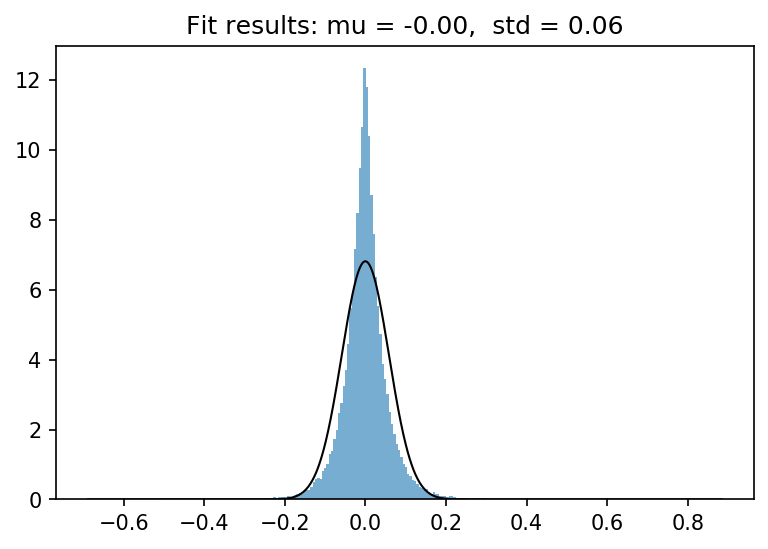

In [58]:
data = df_conc
mu, std = norm.fit(data)
plt.hist(data, bins=250, density=True, alpha=0.6)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, mu, std)
plt.plot(x, p, "k", linewidth=1)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

## Uncouple data completeness and quality

In [76]:
df_fullP = i_class.df_01_stacked_for_quantity.unstack(["Fraction"])["normalized profile"].dropna().stack("Fraction").unstack("Map")

In [82]:
df12_fullP = df_fullP[["Map1", "Map2"]]#, "Fraction"])
df12_fullP = df12_fullP.loc[(df12_fullP!=0).any(1)].dropna()
df23_fullP = df_fullP[["Map2", "Map3"]]#, "Fraction"])
df23_fullP = df23_fullP.loc[(df23_fullP!=0).any(1)].dropna()
df13_fullP = df_fullP[["Map1", "Map3"]]#, "Fraction"])
df13_fullP = df13_fullP.loc[(df13_fullP!=0).any(1)].dropna()

df13_sub_fullP = df13_fullP["Map1"]-df13_fullP["Map3"]
df23_sub_fullP = df23_fullP["Map2"]-df23_fullP["Map3"]
df12_sub_fullP = df12_fullP["Map1"]-df12_fullP["Map2"]
df_conc_fullP = np.concatenate((df13_sub_fullP, df23_sub_fullP, df12_sub_fullP))

In [83]:
px.histogram(df_conc_fullP)

Text(0.5, 1.0, 'Fit results: mu = -0.00,  std = 0.05')

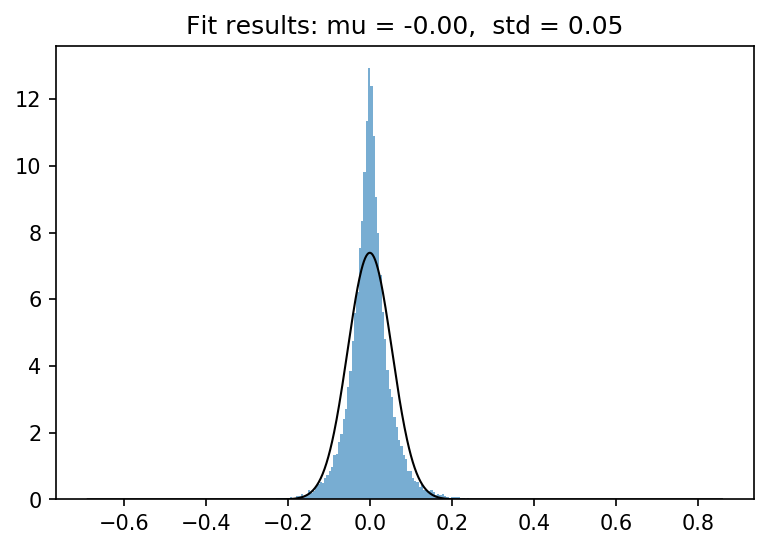

In [85]:
data_fullP = df_conc_fullP
mu_fullP, std_fullP = norm.fit(data_fullP)
plt.hist(data_fullP, bins=250, density=True, alpha=0.6)
xmin_fullP, xmax_fullP = plt.xlim()
x_fullP = np.linspace(xmin_fullP, xmax_fullP, 1000)
p_fullP = norm.pdf(x_fullP, mu_fullP, std_fullP)
plt.plot(x_fullP, p_fullP, "k", linewidth=1)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu_fullP, std_fullP)
plt.title(title)

In [145]:
scale

0.03642108044960366

In [ ]:
from scipy.stats import laplace
from scipy.stats import dgamma
import matplotlib.pyplot as plt

# Global Ranking test

## Evo run 

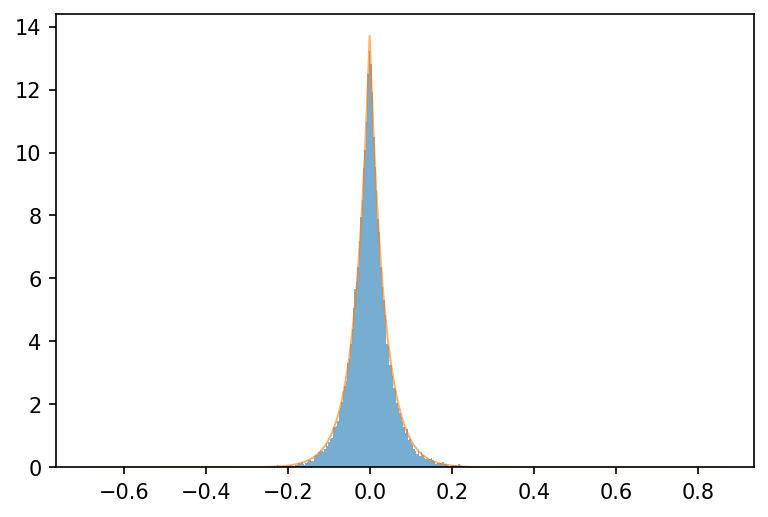

In [144]:
fig, ax = plt.subplots(1, 1)
ax.hist(df_conc_fullP, bins = 400, density=True, alpha=0.6)
xmin_fullP, xmax_fullP = plt.xlim()
x_fullP = np.linspace(xmin_fullP, xmax_fullP, 1000)
loc, scale = dist.fit(df_conc_fullP)
ax.plot(x_fullP, laplace.pdf(x_fullP, loc, scale),
       lw=1, alpha=0.6, label='laplace pdf')
plt.show()

In [149]:
print(loc, scale)

-0.00038810277586513037 0.03642108044960366


In [151]:
print(loc, scale)

-0.0005781951017307038 0.034199426700542074


## MQlive, 33win, 100min, expl, directDIA, MQ

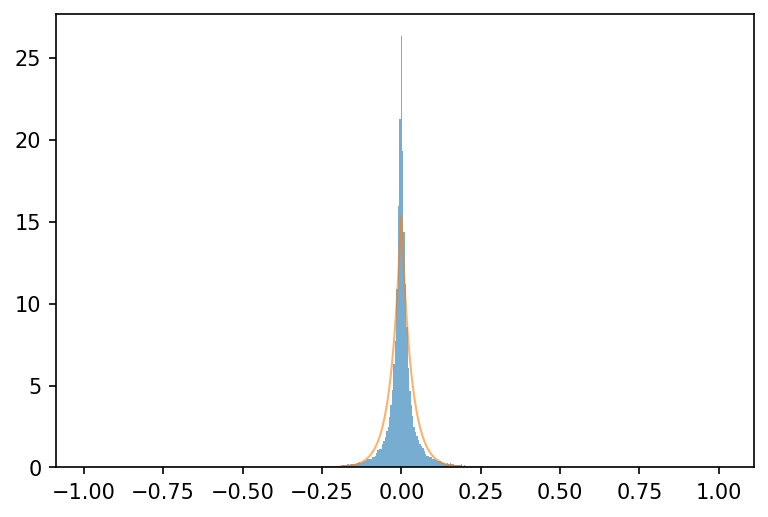

In [190]:
df_fullP = i_class.df_01_stacked_for_quantity.unstack(["Fraction"])["normalized profile"].dropna().stack("Fraction").unstack("Map")
df12_fullP = df_fullP[["MAP1", "MAP2"]]#, "Fraction"])
df12_fullP = df12_fullP.loc[(df12_fullP!=0).any(1)].dropna()
df23_fullP = df_fullP[["MAP2", "MAP3"]]#, "Fraction"])
df23_fullP = df23_fullP.loc[(df23_fullP!=0).any(1)].dropna()
df13_fullP = df_fullP[["MAP1", "MAP3"]]#, "Fraction"])
df13_fullP = df13_fullP.loc[(df13_fullP!=0).any(1)].dropna()

df13_sub_fullP = df13_fullP["MAP1"]-df13_fullP["MAP3"]
df23_sub_fullP = df23_fullP["MAP2"]-df23_fullP["MAP3"]
df12_sub_fullP = df12_fullP["MAP1"]-df12_fullP["MAP2"]
df_conc_fullP = np.concatenate((df13_sub_fullP, df23_sub_fullP, df12_sub_fullP))

fig, ax = plt.subplots(1, 1)
ax.hist(df_conc_fullP, bins = 400, density=True, alpha=0.6)
xmin_fullP, xmax_fullP = plt.xlim()
x_fullP = np.linspace(xmin_fullP, xmax_fullP, 1000)
loc, scale = laplace.fit(df_conc_fullP)

ax.plot(x_fullP, laplace.pdf(x_fullP, loc, scale),
       lw=1, alpha=0.6, label='laplace pdf')
plt.show()

In [191]:
loc, scale

(-0.000530283976926331, 0.03200566931434777)

In [193]:
print(np.percentile(df_conc_fullP, 25), np.percentile(df_conc_fullP, 75))

-0.013914102359381363 0.013793597035982853


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\param\parameterized.py:1451: DtypeWarning:

Columns (196,197) have mixed types.Specify dtype option on import or set low_memory=False.



## MQlive, 33win, 100min, expl, libaryDIA, MQ

In [196]:
print(np.percentile(df_conc_fullP, 25), np.percentile(df_conc_fullP, 75))

-0.01611357315206085 0.015751845837339396


In [166]:
from scipy.stats import dgamma

In [170]:
dist

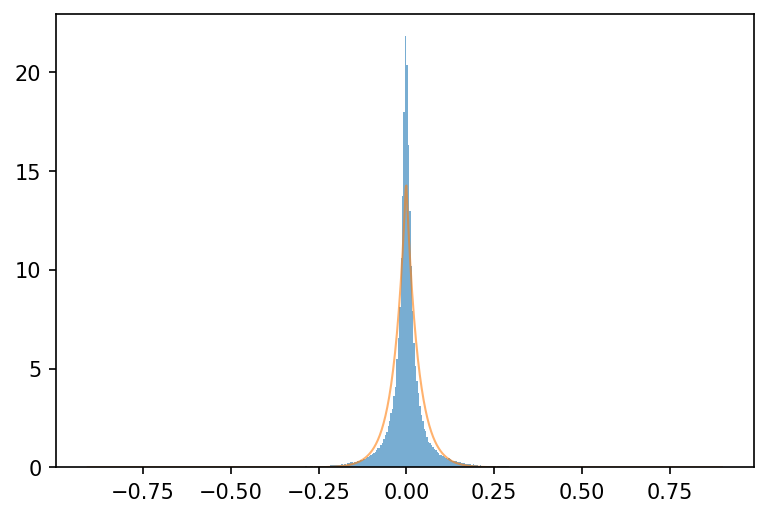

In [195]:
df_fullP = i_class.df_01_stacked_for_quantity.unstack(["Fraction"])["normalized profile"].dropna().stack("Fraction").unstack("Map")
df12_fullP = df_fullP[["Map1", "Map2"]]#, "Fraction"])
df12_fullP = df12_fullP.loc[(df12_fullP!=0).any(1)].dropna()
df23_fullP = df_fullP[["Map2", "Map3"]]#, "Fraction"])
df23_fullP = df23_fullP.loc[(df23_fullP!=0).any(1)].dropna()
df13_fullP = df_fullP[["Map1", "Map3"]]#, "Fraction"])
df13_fullP = df13_fullP.loc[(df13_fullP!=0).any(1)].dropna()

df13_sub_fullP = df13_fullP["Map1"]-df13_fullP["Map3"]
df23_sub_fullP = df23_fullP["Map2"]-df23_fullP["Map3"]
df12_sub_fullP = df12_fullP["Map1"]-df12_fullP["Map2"]
df_conc_fullP = np.concatenate((df13_sub_fullP, df23_sub_fullP, df12_sub_fullP))

fig, ax = plt.subplots(1, 1)
ax.hist(df_conc_fullP, bins = 400, density=True, alpha=0.6)
xmin_fullP, xmax_fullP = plt.xlim()
x_fullP = np.linspace(xmin_fullP, xmax_fullP, 1000)
loc, scale = laplace.fit(df_conc_fullP)

ax.plot(x_fullP, laplace.pdf(x_fullP, loc, scale),
       lw=1, alpha=0.6, label='laplace pdf')
plt.show()

In [187]:
loc, scale

(-0.0005781951017307038, 0.034199426700542074)

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\param\parameterized.py:1451: DtypeWarning:

Columns (176) have mixed types.Specify dtype option on import or set low_memory=False.



##### dgamma

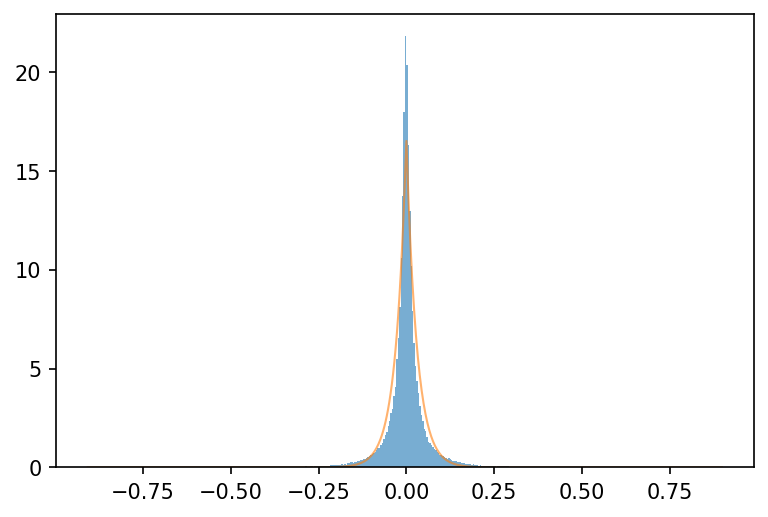

In [184]:
fig, ax = plt.subplots(1, 1)
ax.hist(df_conc_fullP, bins = 400, density=True, alpha=0.6)
xmin_fullP, xmax_fullP = plt.xlim()
x_fullP = np.linspace(xmin_fullP, xmax_fullP, 1000)
a, loc, scale = dgamma.fit(df_conc_fullP)

ax.plot(x_fullP, laplace.pdf(x_fullP, loc, 0.03),
       lw=1, alpha=0.6, label='laplace pdf')
plt.show()

In [178]:
a, loc, scale = dgamma.fit(df_conc_fullP)

(0.7025350854623822, 1.8578320407207642e-20, 0.048691300939421325)

In [158]:
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["foldnorm","genlogistic","gennorm","genpareto","genexpon","genextreme","gausshyper","gamma","gengamma","genhalflogistic","geninvgauss","gilbrat",
"gompertz","gumbel_r","gumbel_l","halfcauchy","halflogistic","halfnorm","halfgennorm","hypsecant","invgamma","invgauss","invweibull","johnsonsb",
"johnsonsu","kappa4","kappa3","kstwo","kstwobign","laplace","laplace_asymmetric","levy","levy_l","logistic","loggamma",
"loglaplace","lognorm","loguniform","lomax","maxwell","mielke","moyal","nakagami","ncx2","ncf","nct","norm","norminvgauss","pareto","pearson3",
"powerlaw","powerlognorm","powernorm","rdist","rayleigh","rice","recipinvgauss","semicircular","skewnorm","t","trapezoid","triang","truncexpon",
"truncnorm","tukeylambda","uniform","vonmises","vonmises_line","wald","weibull_min","weibull_max", "alpha","anglit","arcsine","argus","beta","betaprime","bradford","burr",
     "burr12","cauchy","chi","chi2","cosine","crystalball","dgamma","dweibull","erlang","expon","exponnorm","exponweib","exponpow","f","fatiguelife","fisk","foldcauchy"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        try:
            dist = getattr(st, dist_name)
            param = dist.fit(data)
    
            params[dist_name] = param
            # Applying the Kolmogorov-Smirnov test
            D, p = st.kstest(data, dist_name, args=param)
            print("p value for "+dist_name+" = "+str(p))
            dist_results.append((dist_name, p))
        except:
            continue
    
    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [159]:
get_best_distribution(df_conc_fullP)

p value for foldnorm = 0.0
p value for genlogistic = 0.0
p value for gennorm = 2.9061417708141094e-49
p value for genpareto = 0.0
p value for genexpon = 0.0
p value for genextreme = 0.0


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_distn_infrastructure.py:1722: RuntimeWarning:

invalid value encountered in log



p value for gausshyper = 0.0
p value for gamma = 0.0
p value for gengamma = 0.0
p value for genhalflogistic = 0.0


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:3675: RuntimeWarning:

Infinite values encountered in scipy.special.kve(p, b). Values replaced by NaN to avoid incorrect results.



p value for geninvgauss = 0.0
p value for gilbrat = 0.0
p value for gompertz = 0.0
p value for gumbel_r = 0.0
p value for gumbel_l = 0.0


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_distn_infrastructure.py:2429: RuntimeWarning:

invalid value encountered in double_scalars



p value for halfcauchy = 0.0
p value for halflogistic = 0.0
p value for halfnorm = 0.0
p value for halfgennorm = 0.0
p value for hypsecant = 0.0
p value for invgamma = 0.0
p value for invgauss = 0.0


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_distn_infrastructure.py:1722: RuntimeWarning:

divide by zero encountered in log



p value for invweibull = 0.0
p value for johnsonsb = 0.0
p value for johnsonsu = 8.149884596061133e-09
p value for kappa4 = 0.0
p value for kappa3 = 0.0
p value for kstwobign = 0.0
p value for laplace = 0.0
p value for levy = 0.0
p value for levy_l = 0.0
p value for logistic = 0.0
p value for loggamma = 0.0


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:4965: RuntimeWarning:

divide by zero encountered in true_divide



p value for loglaplace = 0.0
p value for lognorm = 0.0
p value for loguniform = 0.0
p value for lomax = 0.0
p value for maxwell = 0.0
p value for mielke = 0.0
p value for moyal = 0.0


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:5713: RuntimeWarning:

overflow encountered in double_scalars



p value for nakagami = 0.0
p value for ncx2 = 0.0
p value for nct = 1.6364789227828562e-23
p value for norm = 0.0
p value for pareto = 0.0
p value for pearson3 = 0.0
p value for powerlaw = 0.0
p value for powerlognorm = 0.0
p value for powernorm = 0.0
p value for rdist = 0.0
p value for rayleigh = 0.0
p value for rice = 0.0


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:6765: RuntimeWarning:

overflow encountered in exp

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:6765: RuntimeWarning:

invalid value encountered in multiply

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning:

invalid value encountered in less_equal



p value for recipinvgauss = nan
p value for semicircular = 0.0
p value for t = 3.0918764196858844e-28
p value for triang = 0.0
p value for truncexpon = 0.0
p value for truncnorm = 0.0


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:7738: RuntimeWarning:

divide by zero encountered in power



p value for uniform = 0.0
p value for vonmises = 0.0
p value for vonmises_line = 0.0
p value for wald = 0.0
p value for weibull_min = 0.0
p value for weibull_max = 0.0
p value for alpha = 0.0
p value for anglit = 0.0


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:496: RuntimeWarning:

divide by zero encountered in true_divide



p value for arcsine = 0.0
p value for argus = 0.0


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



p value for beta = 0.0


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:781: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:785: RuntimeWarning:

divide by zero encountered in true_divide



p value for betaprime = 0.0
p value for bradford = 0.0
p value for burr = 0.0
p value for burr12 = 0.0
p value for cauchy = 9.41054123240936e-25
p value for chi = 0.0
p value for chi2 = 0.0
p value for cosine = 0.0
p value for crystalball = 0.0
p value for dgamma = 4.715603687366208e-128
p value for dweibull = 4.655330301629254e-75


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 506.1.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 457.9.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 494.05.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 490.0333333333333.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape pa

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 489.91839272347056.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 489.8362927358332.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 489.2444658978487.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 490.5716958202465.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 558.5623888014845.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 569.9539563137058.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 568.3069979101151.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 573.1793024644303.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 661.884663175748.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 659.5937147328509.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 663.0973673266851.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 672.1258460992486.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 811.5078480501863.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 784.4225043074822.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 780.4054838199111.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 797.7130666394137.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 894.8006742854795.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 919.9674111088696.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 922.927474804033.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 932.8455468071807.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 1023.6360712576748.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 1034.8196416345158.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 1033.1150729473434.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 1047.408416525183.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 1086.4026823870086.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 1094.8880000837012.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 1076.068599287284.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 1072.8925234255203.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 1212.6814567409283.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 1190.0467922919129.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 1188.8023530358146.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 1204.741360065539.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 1244.0132632676896.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 1244.5015880847013.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 1249.1220541016319.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 1255.0630355730318.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns

p value for erlang = 0.0
p value for expon = 0.0
p value for exponnorm = 0.0
p value for exponweib = 0.0
p value for exponpow = 0.0
p value for f = 0.0
p value for fatiguelife = 0.0
p value for fisk = 0.0
p value for foldcauchy = 0.0
Best fitting distribution: johnsonsu
Best p value: 8.149884596061133e-09
Parameters for the best fit: (-0.014512974792564273, 0.6519268974937826, -0.0007568863119604956, 0.01297093269957418)


('johnsonsu',
 8.149884596061133e-09,
 (-0.014512974792564273,
  0.6519268974937826,
  -0.0007568863119604956,
  0.01297093269957418))

In [99]:
get_best_distribution(df_conc_fullP)

p value for foldnorm = 1.208428553861105e-248
p value for genlogistic = 3.151680072500786e-50
p value for gennorm = 1.9632589051911392e-05
p value for genpareto = 0.0
p value for genexpon = 0.0
p value for genextreme = 0.0
p value for gamma = 7.004821054792631e-247
p value for gengamma = 3.7392236026588988e-233
p value for genhalflogistic = 0.0
p value for gilbrat = 0.0
p value for gompertz = 0.0
p value for gumbel_r = 0.0
p value for gumbel_l = 0.0
p value for halfcauchy = 0.0
p value for halflogistic = 0.0
p value for halfnorm = 0.0
p value for halfgennorm = 0.0
p value for hypsecant = 6.215553485351407e-34
p value for invgamma = 3.8475264503423185e-285
p value for invgauss = 1.6990215239174622e-283
p value for invweibull = 0.0
p value for johnsonsb = 3.3572253101346427e-247
p value for johnsonsu = 3.353506366699258e-05
p value for kappa4 = 0.0
p value for kappa3 = 0.0
p value for laplace = 0.042340160159411444
p value for levy = 0.0
p value for levy_l = 0.0


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:4523: IntegrationWarning:

The integral is probably divergent, or slowly convergent.



p value for logistic = 3.7141098855384784e-65
p value for loggamma = 4.7033166741348685e-254


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:4965: RuntimeWarning:

divide by zero encountered in true_divide



p value for loglaplace = 0.017355800083021875
p value for lognorm = 1.7125359385708374e-236
p value for loguniform = 0.0
p value for lomax = 0.0
p value for maxwell = 0.0
p value for mielke = 2.3098617334470274e-175
p value for moyal = 0.0


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:5713: RuntimeWarning:

overflow encountered in double_scalars



p value for nakagami = 2.7419992168162296e-239
p value for ncx2 = 0.0
p value for ncf = 0.0
p value for nct = 5.5231953412677916e-08
p value for norm = 1.3588793388851089e-248
p value for norminvgauss = 0.000985889608446534
p value for pareto = 0.0
p value for pearson3 = 1.670350291336704e-238
p value for powerlaw = 0.0
p value for powerlognorm = 1.011185559424713e-234
p value for powernorm = 1.691460243491441e-241
p value for rdist = 0.0
p value for rayleigh = 0.0
p value for rice = 1.5175718129870449e-248


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:6765: RuntimeWarning:

overflow encountered in exp

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:6765: RuntimeWarning:

invalid value encountered in multiply

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning:

invalid value encountered in less_equal



p value for recipinvgauss = nan
p value for semicircular = 0.0
p value for skewnorm = 1.7299697541723329e-220
p value for t = 4.582555342637328e-08
p value for triang = 0.0
p value for truncexpon = 0.0
p value for truncnorm = 0.0


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:7738: RuntimeWarning:

divide by zero encountered in power



p value for tukeylambda = 1.2944104021110745e-11
p value for uniform = 0.0
p value for vonmises = 0.0
p value for vonmises_line = 0.0
p value for wald = 0.0
p value for weibull_min = 0.0
p value for weibull_max = 0.0
Best fitting distribution: laplace
Best p value: 0.042340160159411444
Parameters for the best fit: (-0.00038810277586513037, 0.03642108044960366)


('laplace',
 0.042340160159411444,
 (-0.00038810277586513037, 0.03642108044960366))

In [93]:
get_best_distribution(df_conc_fullP)

p value for norm = 1.3588793388851089e-248
p value for alpha = 2.711274117705272e-243
p value for anglit = 0.0


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:496: RuntimeWarning:

divide by zero encountered in true_divide



p value for arcsine = 0.0
p value for argus = 0.0


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:621: RuntimeWarning:

invalid value encountered in sqrt

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



p value for beta = 4.10962384489858e-241


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:781: RuntimeWarning:

divide by zero encountered in true_divide

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:785: RuntimeWarning:

divide by zero encountered in true_divide



p value for betaprime = 5.409829660140448e-233
p value for bradford = 0.0
p value for burr = 1.5959230707458256e-47
p value for burr12 = 1.38557218364983e-53
p value for cauchy = 5.121212350465361e-76
p value for chi = 4.625072834642712e-236
p value for chi2 = 0.0
p value for cosine = 0.0
p value for crystalball = 1.9674636171271385e-230
p value for dgamma = 0.006670038676529256
p value for dweibull = 0.0005726146433563795


C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 44.1.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 39.9.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 37.8.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 39.2.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the er

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 8.622501674116759.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 6.92882556687073.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 8.070352601366643.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 8.125957700980152.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 56.88600592104104.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 57.66828093809977.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 60.74530946981643.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 60.577239882670696.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 126.10530764210885.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 125.78593331914522.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 126.35151927459276.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 125.657204996366.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.p

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 126.38119874264362.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 126.4325605951939.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 126.56379640842079.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 126.68304772085665.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 209.83372843714307.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 214.12046340793404.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 205.84723453485032.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns.py:2958: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 211.23097028452298.

C:\Users\valbrecht\Anaconda3\envs\QC repository\lib\site-packages\scipy\stats\_continuous_distns

p value for erlang = 1.4367268426267057e-278
p value for expon = 0.0
p value for exponnorm = 8.181915662289647e-196
p value for exponweib = 1.9087079133772576e-261
p value for exponpow = 0.0
p value for f = 1.1785212477362419e-251
p value for fatiguelife = 2.2000657349354144e-237
p value for fisk = 3.237593202444126e-53
p value for foldcauchy = 1.474284498152055e-160
Best fitting distribution: dgamma
Best p value: 0.006670038676529256
Parameters for the best fit: (0.9821223418633598, -3.4958008422409966e-20, 0.03708549415976618)


('dgamma',
 0.006670038676529256,
 (0.9821223418633598, -3.4958008422409966e-20, 0.03708549415976618))

In [ ]:
MAP1_imp = i_class.df_01_stacked.unstack(["Map", "Fraction"])["normalized profile"]["Map1"].values
MAP2_imp = i_class.df_01_stacked.unstack(["Map", "Fraction"])["normalized profile"]["Map2"].values
MAP3_imp = i_class.df_01_stacked.unstack(["Map", "Fraction"])["normalized profile"]["Map3"].values
MAP1_imp_noNAN = np.nan_to_num(MAP1_imp)
MAP2_imp_noNAN = np.nan_to_num(MAP2_imp)
MAP3_imp_noNAN = np.nan_to_num(MAP3_imp)
MAP1_MAP3_noNAN = MAP1_imp_noNAN-MAP3_imp_noNAN
MAP1_MAP2_noNAN = MAP1_imp_noNAN-MAP2_imp_noNAN
MAP2_MAP3_noNAN = MAP2_imp_noNAN-MAP3_imp_noNAN
MAP_CONCACT = np.concatenate((MAP1_MAP3_noNAN, MAP1_MAP2_noNAN, MAP2_MAP3_noNAN), axis=0)
MAP_CONCACT_noZ = MAP_CONCACT[~np.all(MAP_CONCACT == 0, axis=1)]
MAP1_MAP3_noZ = MAP1_MAP3_noNAN[~np.all(MAP1_MAP3_noNAN == 0, axis=1)]
MAP1_MAP2_noZ = MAP1_MAP2_noNAN[~np.all(MAP1_MAP2_noNAN == 0, axis=1)]
MAP2_MAP3_noZ = MAP2_MAP3_noNAN[~np.all(MAP2_MAP3_noNAN == 0, axis=1)]
df_globalDeltaProfiles_Z = pd.DataFrame(MAP_CONCACT_noZ).stack()
px.histogram(df_globalDeltaProfiles_Z)

In [ ]:
from numpy import mean,std
from scipy import stats
from scipy.stats import norm

mean = mean(df_globalDeltaProfiles_Z)
std = std(df_globalDeltaProfiles_Z)
print (mean, std)
pdf = stats.norm.pdf(values)
distribution = norm(mean, std)

min_weight = min(df_globalDeltaProfiles_Z)
max_weight = max(df_globalDeltaProfiles_Z)
#values = list(range(int(min_weight), int(max_weight), 0.01))
probabilities = [distribution.pdf(v) for v in x]

pyplot.hist(df_globalDeltaProfiles_Z, bins=200, density=True) # , 
pyplot.plot(x, probabilities)

probabilities = [distribution.pdf(v) for v in x]
pyplot.hist(df_globalDeltaProfiles_unimputed, bins=200, density=True) # , 
pyplot.plot(x, probabilities)

In [ ]:
#df_eLifeMarkers = pd.read_csv("eLife_markers.txt", sep="\t", comment="#",
#                                       usecols=lambda x: bool(re.match("Gene name|Compartment", x)))
#df_eLifeMarkers = df_eLifeMarkers.rename(columns={"Gene name":"Gene names"})
#df_eLifeMarkers = df_eLifeMarkers.astype({"Gene names": "str"})
#i_class.df_eLifeMarkers =  df_eLifeMarkers

In [ ]:
#import plotly.figure_factory as ff
#
#fig = ff.create_distplot(df.reset_index(), group_labels, colors=colors, bin_size=.25,
#                         show_curve=False)
#
## Add title
#fig.update_layout(title_text="Hist and Rug Plot")
#fig.show()
#

#df_cluster_normalizedMedian.index.name="Experiment"
#df_cluster_normalizedMedian.rename_axis("Cluster", axis=1, inplace=True)
#df_ranking = df_cluster_normalizedMedian.stack("Cluster")
#df_ranking.name="Normalized Median"
#df_ranking = df_ranking.reset_index()
#ranking_sum = df_cluster_normalizedMedian.sum(axis=1).round(2)
#ranking_sum.name = "Normalized Median - Sum"

#clusters_for_ranking = i_class_comp.clusters_for_ranking
#ref_exp = i_ref_exp.value
#ranking_boxPlot=True
#collapse_cluster=False
#
#df_distance_comp = i_class_comp.df_distance_comp.copy()
#df_distance_comp = df_distance_comp[df_distance_comp["Experiment"].isin(multi_choice)]
#df_distance_comp = df_distance_comp[df_distance_comp["Cluster"].isin(clusters_for_ranking)]
#
#df_quantified_cluster = df_distance_comp.reset_index()
#df_quantified_cluster = df_quantified_cluster.drop_duplicates(subset=["Cluster", "Experiment"]).set_index(["Cluster", 
#                                                                                                           "Experiment"])["distance"].unstack("Cluster")
#i_class_comp.df_quantified_cluster = df_quantified_cluster.notnull().replace({True: "x", False: "-"})
#
##dict_cluster_normalizedMedian = {}
#dict_cluster_normalizedMedian_ref = {}
#dict_median_distance_ranking = {}
#for cluster in i_class_comp.markerproteins.keys():
#    try:
#        df_cluster = df_distance_comp[df_distance_comp["Cluster"]==cluster]
#        all_median_one_cluster_several_exp = {}
#        for exp in multi_choice:
#            median = df_cluster[df_cluster["Experiment"]==exp].median()
#            all_median_one_cluster_several_exp[exp] = float(median)
#            #new
#            if exp == ref_exp:
#                ref = median
#        dict_median_distance_ranking[cluster] = all_median_one_cluster_several_exp
#        min_median = min(all_median_one_cluster_several_exp.items(), key=lambda x: x[1])[1]
#        #median_ranking = {exp: median/min_median for exp, median in all_median_one_cluster_several_exp.items()}
#        #dict_cluster_normalizedMedian[cluster] = median_ranking
#        #new
#        median_ranking_ref = {exp: median/ref[0] for exp, median in all_median_one_cluster_several_exp.items()}
#        dict_cluster_normalizedMedian_ref[cluster] = median_ranking_ref
#    except Exception:
#        continue
#
##df_cluster_normalizedMedian = pd.DataFrame(dict_cluster_normalizedMedian)
##df_cluster_normalizedMedian.index.name="Experiment"
##df_cluster_normalizedMedian.rename_axis("Cluster", axis=1, inplace=True)
##df_ranking = df_cluster_normalizedMedian.stack("Cluster")
##df_ranking.name="Normalized Median"
##df_ranking = df_ranking.reset_index()
##ranking_sum = df_cluster_normalizedMedian.sum(axis=1).round(2)
##ranking_sum.name = "Normalized Median - Sum"
##ranking_product = df_cluster_normalizedMedian.product(axis=1).round(2)
##ranking_product.name = "Normalized Median - Product"
##df_globalRanking = pd.concat([pd.DataFrame(ranking_sum), pd.DataFrame(ranking_product)], axis=1).reset_index()
##self.sorting_list = list(df_globalRanking.sort_values("Normalized Median - Sum")["Experiment"])
##set categroical column, allowing lexicographic sorting
##df_ranking = df_ranking.assign(Experiment_lexicographic_sort = pd.Categorical(df_ranking["Experiment"], categories=self.sorting_list, ordered=True))
##df_ranking.sort_values("Experiment_lexicographic_sort", inplace=True)
##df_globalRanking = df_globalRanking.assign(Experiment_lexicographic_sort = pd.Categorical(df_globalRanking["Experiment"], categories=self.sorting_list,
##                                                                                          ordered=True))
##df_globalRanking.sort_values("Experiment_lexicographic_sort", inplace=True)
##df_ranking["Experiment_lexicographic_sort"] = pd.Categorical(df_ranking["Experiment"], categories=self.sorting_list, ordered=True)
##df_ranking.sort_values("Experiment_lexicographic_sort", inplace=True)
##df_globalRanking["Experiment_lexicographic_sort"] = pd.Categorical(df_globalRanking["Experiment"], categories=self.sorting_list, ordered=True)
##df_globalRanking.sort_values("Experiment_lexicographic_sort", inplace=True)
#
#df_cluster_normalizedMedian_ref = pd.DataFrame(dict_cluster_normalizedMedian_ref)
#df_cluster_normalizedMedian_ref.index.name="Experiment"
#df_cluster_normalizedMedian_ref.rename_axis("Cluster", axis=1, inplace=True)
#
##median makes a huge differnece, improves result of DIA, MQ, libary
#df_RelDistanceRanking = pd.concat([df_cluster_normalizedMedian_ref.median(axis=1), df_cluster_normalizedMedian_ref.sem(axis=1)], axis=1, 
#                                  keys=["Distance Ranking (rel, median)", "SEM"]).reset_index().sort_values("Distance Ranking (rel, median)")
#i_class_comp.sorting_list = list(df_RelDistanceRanking["Experiment"])


#    if i_class_comp.multi_choice not in list(i_class_comp.json_dict.keys()):
#    #        i_class_comp.multi_choice = list(i_class_comp.json_dict.keys())[0:2] 
#            i_multi_choice.value = list(i_class_comp.json_dict.keys())[0:2] 
#        
#    if i_class_comp.i_clusterwidget not in list(i_class_comp.json_dict.keys()):
##        i_class_comp.multi_choice = list(i_class_comp.json_dict.keys())[0:2] 
#        i_multi_choice.value = list(i_class_comp.json_dict.keys())[0:2] 
#    
#    if i_class_comp.i_clusters_for_ranking not in list(i_class_comp.json_dict.keys()):
##    i_class_comp.multi_choice = list(i_class_comp.json_dict.keys())[0:2] 
#    i_multi_choice.value = list(i_class_comp.json_dict.keys())[0:2] 
#            
##def update_object_selector(i_mapwidget, i_clusterwidget):
##    i_mapwidget.options = list(i_class.map_names)
##    i_clusterwidget.options = list(i_class.markerproteins.keys())

    
#def update_multi_choice_venn(i_multi_choice_venn):
#    i_multi_choice_venn.options = list(json_dict.keys())
    #i_multi_choice_venn.value = list(json_dict.keys())[0:2]
    
    #if i_class_comp.multi_choice_venn not in list(i_class_comp.json_dict.keys()):
    #        i_class_comp.multi_choice_venn = list(i_class_comp.json_dict.keys())[0:2]  
    #        i_multi_choice_venn.value = list(i_class_comp.json_dict.keys())[0:2] 
     
        
#                   i_renameExp.disabled =  False
                    #dict_old_new_ExpName = dict.fromkeys(json_dict_amendments_intended.keys(), "")
#                    i_renameExp.disabled =  True
                    #dict_old_new_ExpName = dict.fromkeys(json_dict_amendments_intended.keys(), "")
                #filereading_status_json = list(json_dict_amendments_intended.keys())
              
    #        for key in dict_old_new_ExpName.keys():
    #            if dict_old_new_ExpName[key] == "":
    #                dict_old_new_ExpName[key] = key  
    
#    i_renameExp.disabled = False
#    i_renameExp.options = json_ExpSelector
#    return i_renameExp 
#
#@pn.depends(i_renameExp_text.param.value, watch=True)
#def update_dict_expName(renameExp_text):
#    dict_old_new_ExpName[i_renameExp.value] = renameExp_text 
#
#@pn.depends(i_renameExp.param.value, watch=True)
#def update_text(renameExp):
#    i_renameExp_text.value = dict_old_new_ExpName[renameExp]





####SILAC
###df_data_completeness = i_class.df_index["Ratio H/L"].stack(["Fraction"])
###data_completeness = 1-df_data_completeness.apply(np.isnan).apply(sum)/len(df_data_completeness)
###data_completeness = data_completeness.append(pd.Series(data_completeness.mean(), index=["combined"]))
###data_completeness.rename("Data completness", inplace=True)
####LFQ
###df_data_completeness = i_class.df_index["LFQ intensity"].stack(["Fraction"])
###data_completeness = 1-df_data_completeness.apply(np.isnan).apply(sum)/len(df_data_completeness)
###data_completeness = data_completeness.append(pd.Series(data_completeness.mean(), index=["combined"]))
###data_completeness.rename("Data completness", inplace=True)
####LFQ and SILAC
###df_profile_completeness = i_class.df_01_stacked["normalized profile"].xs(i_class.fractions[0], level="Fraction", axis=0).unstack(["Map"])
###profile_completeness = 1-df_profile_completeness.apply(np.isnan).apply(sum)/len(df_profile_completeness)
###profile_completeness = profile_completeness.append(pd.Series(profile_completeness.mean(), index=["combined"]))
###profile_completeness.rename("Profile completness", inplace=True)





###
###df_completeness = pd.concat([data_completeness, profile_completeness], axis=1)
###df_completeness.index.name = "Map"###################
#SVM
###################

#df_01_test = i_class.df_01_stacked.copy()
#
##df_01_filtered_combined = df_01_filtered_combined.stack(["Experiment", "Map"]).swaplevel(0,1, axis=0).dropna(axis=1)
#index_ExpMap = df_01_test.index.get_level_values("Map")+"_"+df_01_test.index.get_level_values("Fraction")
#index_ExpMap.name = "Map_Frac"
#df_01_test.set_index(index_ExpMap, append=True, inplace=True)      
#
#df_01_test.index = df_01_test.index.droplevel(["Map", "Fraction"])
#df_01_test = df_01_test.unstack("Map_Frac")
#df_01_test.columns = ["_".join(col) for col in df_01_test.columns.values]
#df_01_test.rename(index={"undefined" : np.nan}, level="Compartment", inplace=True)
#df_01_test
#compartments = i_class.df_eLifeMarkers["Compartment"].unique()
#compartment_color = dict(zip(compartments, i_class.css_color))
#compartment_color["undefined"] = "lightgrey"
#
#collapse_maps_PCA_test = False
#df_global_pca = i_class.df_pca.unstack("Map").swaplevel(0,1, axis=1)[i_class.map_of_interest].reset_index()
##        else:
# #           df_global_pca = self.df_pca.rename_axis("PC", axis="columns").unstack("Map").stack("PC").median(axis=1).to_frame().unstack("PC")
# #           df_global_pca.columns = df_global_pca.columns.droplevel()
  #          df_global_pca.reset_index(inplace=True)

#if collapse_maps_PCA_test == False:
#    title_PCA = "Protein subcellular localization by PCA of {}".format(i_class.map_of_interest)
#else:
#    title_PCA = "Protein subcellular localization by PCA of combined maps"
        
#fig_global_pca = px.scatter(data_frame=df_global_pca,
#                            x="PC1",
#                            y="PC3",
#                            color="Compartment",
#                            color_discrete_map=compartment_color,
#                            title= "Protein subcellular localization by PCA for {}".format(i_class.map_of_interest) 
#                            if collapse_maps_PCA_test == False else "Protein subcellular localization by PCA of combined maps", 
#                            #title_PCA,
#                            hover_data=["Protein IDs", "Gene names", "Compartment"],
#                    #       custom_data=df_annotated_all.columns,
#                            opacity=0.9
#                            )
#fig_global_pca       
######################################################WITH RNAKING 
##dict_cluster_ranking = {}
##dict_cluster_normalizedMedian = {}
##for cluster in i_class.markerproteins.keys():
##    df_cluster = df_distance_map_cluster_gene_in_index.xs(cluster, level="Cluster")
##    all_median_one_cluster_several_exp = {}
##    for exp in i_class.json_dict.keys():
##        median = df_cluster.xs(exp, level="Experiment").median()
##        #df_cluster[df_cluster.index.get_level_values("Experiment").isin([exp])].median()
##        all_median_one_cluster_several_exp[exp] = float(median)
##    
##    min_median = min(all_median_one_cluster_several_exp.items(), key=lambda x: x[1])[1]
##    median_ranking = {exp: median/min_median for exp, median in all_median_one_cluster_several_exp.items()}
##    dict_cluster_normalizedMedian[cluster] = median_ranking
##    
##    dict_cluster_normalizedMedian[cluster] = median_ranking
##    
##    ranking_one_cluster = {key: rank for rank, key in enumerate(sorted(all_median_one_cluster_several_exp, key=all_median_one_cluster_several_exp.get), 1)}
##    dict_cluster_ranking[cluster] = ranking_one_cluster
##
##df_ranking = pd.concat([pd.DataFrame(dict_cluster_ranking), pd.DataFrame(dict_cluster_normalizedMedian)], keys=["Ranking", "Normalized median"], names=["Type", "Experiment"])   
##df_ranking.rename_axis("Cluster", axis=1, inplace=True)
##df_rank_for_plot = df_ranking.unstack("Type").stack("Cluster").reset_index()
##df_rank_for_plot = df_rank_for_plot.sort_values(["Normalized median", "Experiment"])
##fig2 =px.bar(df_rank_for_plot, x="Cluster", y="Normalized median", color="Experiment", barmode="group")
##fig2.update_xaxes(categoryorder="total ascending")
##fig2 

##ranking_sum = df_ranking.sum(axis=1).round(2)
##df_ranking2 = df_ranking.copy()
##df_ranking2["Ranking - Product"] = df_ranking2.product(axis=1).round(2)
##df_ranking2["Ranking - Sum"] = ranking_sum
##df_ranking2

#on_validProfiles2 = {}
#or maps in i_class.map_names : 
#   series_non_validProfiles_map = df_MQ["normalized profile"].xs(maps, level="Map").unstack("Fraction").apply(lambda x: x.isnull().any(), axis=1)
#   total_protein_ids_map = len(series_non_validProfiles_map)
#   non_validProfiles_map = len(series_non_validProfiles_map[series_non_validProfiles_map == True].index)
#   non_validProfiles2[maps] = non_validProfiles_map/total_protein_ids_map*100
#eries_non_validProfiles_combined = df_MQ.unstack(["Fraction", "Map"])["normalized profile"].apply(lambda x: x.isnull().any(), axis=1)
#otal_protein_ids_combined = len(series_non_validProfiles_combined)
#on_validProfiles_combined = len(series_non_validProfiles_combined[series_non_validProfiles_combined == True].index)
#on_validProfiles2["combined maps"] = non_validProfiles_combined/total_protein_ids_combined*100
#self.shape_dict["Non valid profiles"] = non_validProfiles
#on_validProfiles2


##df_lognorm_MAP1 = df_lognorm_ratio_stacked.loc(axis=0)[:,:,:,:,:,:,:,:,["MAP1"]]
##px.histogram(df_lognorm_MAP1.reset_index(), 
##x="normalized profile",
##color="Map_Frac",
##facet_row="Map_Frac")
#
#timsTOF = i_class.df_01_stacked.copy()
#timsTOF_tojson = i_class.df_01_stacked["normalized profile"].unstack("Map").median(axis=1).to_frame(name="normalized profile")#.unstack("PC")
#
#
#test_summary_dict = {"timsTOF" : {"0/1 normalized data" : timsTOF_tojson.reset_index().to_json() }}
#test_summary_dict["Expl"] = {"0/1 normalized data" : Expl_tojson.reset_index().to_json() }
#
#for exp_name in test_summary_dict.keys():
#    #print(exp_name)
#    for data_type in test_summary_dict[exp_name].keys():
#        if data_type == "0/1 normalized data" and exp_name == list(test_summary_dict.keys())[0]:
#            #convert into dataframe
#            df_01_combined = pd.read_json(test_summary_dict[exp_name][data_type])
#            #get only 01 normalized data 
#            df_01_combined = df_01_combined.set_index(["Fraction", "Gene names", "Protein IDs", "Compartment"])[["normalized profile"]].unstack(["Fraction"])
#            df_01_combined.rename(columns = {"normalized profile":exp_name}, inplace=True)
#
#        elif data_type == "0/1 normalized data" and exp_name != list(test_summary_dict.keys())[0]:
#            df_01_toadd = pd.read_json(test_summary_dict[exp_name][data_type])
#            df_01_toadd = df_01_toadd.set_index(["Fraction", "Gene names", "Protein IDs", "Compartment"])[["normalized profile"]].unstack(["Fraction"])
#            df_01_toadd.rename(columns = {"normalized profile":exp_name}, inplace=True)
#            #dataframes will be concatenated, only proteins/Profiles that are in both df will be retained
#            df_01_combined = pd.concat([df_01_combined, df_01_toadd], axis=1, join="inner")
#            
#            
#df_01_filtered_combined = df_01_combined.dropna()    
#df_01_filtered_combined.columns.names = ["Experiment", "Fraction"]
##reframe it to make it ready for PCA
#df_01_filtered_combined = df_01_filtered_combined.stack(["Experiment"])
#
#
#pca = PCA(n_components=3)
#
## df_pca: PCA processed dataframe, containing the columns "PC1", "PC2", "PC3"
#df_pca = pd.DataFrame(pca.fit_transform(df_01_filtered_combined))
#df_pca.columns = ["PC1", "PC2", "PC3"]
#df_pca.index = df_01_filtered_combined.index
#
#
#
#df_pca_for_plotting = i_class.df_global_pca_for_plotting
#df_pca_for_plotting
#
#
#fig_pca = px.scatter(data_frame=i_class.df_global_pca_for_plotting.reset_index(),
#                     x="PC1",
#                     y="PC3",
#                     color="Compartment",
#                     color_discrete_map={
#                         "undefined": "lightgrey",
#                         "Endosome": "green",
#                         "Ergic/cisGolgi": "blue",
#                         "Large Protein Complex": "orange",
#                         "Nuclear pore complex": "purple",
#                         "Peroxisome" : "goldenrod",
#                         "Lysosome": "yellow",
#                         "Plasma membrane" : "lightcoral",
#                         "Actin binding proteins" : "magenta",
#                         "ER": "brown",
#                         "ER_high_curvature" : "lightpink",
#                         "Golgi": "red",
#                         "Mitochondrion": "turquoise",
#                     },
#                     facet_col="Experiment",
#                     #facet_col_wrap=4,
##  facet_col_wrap=len(i_class.fractions),     
#                         
#                     )
#fig_pca
#
#
##compartments = self.df_eLifeMarkers["Compartment"].unique()
##compartment_color = dict(zip(compartments, css_color))
##compartment_color["undefined"] = "lightgrey"
#
#fig_pca = px.scatter(data_frame=i_class.df_pca.reset_index(),
#                     x="PC1",
#                     y="PC3",
#                     color="Compartment",
#                     color_discrete_map=compartment_color,
#                    title="Protein subcellular localization by PCA",
#                    hover_data=["Gene names", "Compartment"], #"Protein names", 
#                    #custom_data=df_annotated_all.columns,
#                    opacity=0.9
#                    )
#fig_pca                         

#df_fractionnumber_stacked = i_class.df_index.copy().stack("Fraction")
#number_fractions = len(df_fractionnumber_stacked.index.get_level_values("Fraction").unique())
#
#df_index = i_class.df_index.stack("Map")
#df_index.sort_index(axis=1, level=0, inplace=True)
#df_mscount_mapstacked = df_index.loc[df_index[("MS/MS count")].apply(np.sum, axis=1) >= (
#        number_fractions * 2)]
#df_stringency_mapfracstacked = df_mscount_mapstacked.copy()
#df_stringency_mapfracstacked = df_stringency_mapfracstacked.loc[
#    df_stringency_mapfracstacked[("LFQ intensity")].apply(lambda x: any(
#        np.invert(np.isnan(x)).rolling(window=4).sum() >=
#        4), axis=1)]
#df_stringency_mapfracstacked = df_stringency_mapfracstacked.copy().stack("Fraction")
#
#df_stringency_mapfracstacked

#df_eLifeMarkers = pd.read_csv("eLife_markers.txt", sep="\t", comment="#",
#                                       usecols=lambda x: bool(re.match("Gene name|Compartment", x)))
#df_eLifeMarkers = df_eLifeMarkers.rename(columns={"Gene name":"Gene names"})
#df_eLifeMarkers = df_eLifeMarkers.astype({"Gene names": "str"})
#df_eLifeMarkers

#df_index_annotated_noIndex = df_stringency_mapfracstacked.reset_index()
#df_index_annotated_noIndex = df_index_annotated_noIndex.merge(df_eLifeMarkers, how="outer", on="Gene names", indicator = True)
##df_index_annotated_noIndex = df_index_annotated_noIndex.sort_values("Compartment")
#df_an = df_index_annotated_noIndex.loc[df_index_annotated_noIndex["_merge"].isin(["both","left_only"])].drop("_merge", axis=1)
#df_an.set_index([c for c in df_an.columns if c != "MS/MS count" and c != "LFQ intensity"], inplace=True)
#df_an.rename(index={np.nan : "undefined"}, level="Compartment", inplace=True)
#df_an

#df_pca_MAP1 = i_class.df_pca.unstack("Map").swaplevel(0,1, axis=1)["Map2"].reset_index()
#df_pca_MAP1

#fig_pca = px.scatter(data_frame=df_pca_MAP1,
#                     x="PC1",
#                     y="PC3",
#                     color="Compartment",
#                     color_discrete_map=compartment_color,
#                    title="Protein subcellular localization by PCA",
#                    hover_data=["Gene names", "Compartment"], #"Protein names", 
#                    #custom_data=df_annotated_all.columns,
#                    opacity=0.9
#                    )
#fig_pca  


#i_class.df_pca.query("Compartment == "ER" or Compartment == "Plasma membrane"")#"& Compartment == "Plasma memebrane"")  and 

#json_dict = ast.literal_eval(i_jsonFile.value.decode("UTF-8"))



#    @pn.depends(i_SVM_table.param.value, cache_run.param.value)
#def read_SVM_matrix(SVM_table, run):   
#    try:
#        if run == True:
#            if SVM_table == "":
#                SVM_reading_status = "No misclassification matrix is uploaded"
#                cache_uploaded_SVM.value = False
#            else:
#                cache_uploaded_SVM.value = False
#                try:
#                    i_class.df_SVM = pd.read_table(StringIO(SVM_table), sep="\t")
#                    SVM_reading_status = i_class.df_SVM
#                    cache_uploaded_SVM.value = True
#                    return pn.Column(pn.Pane(SVM_reading_status, width=60*SVM_reading_status.shape[1]),
#                                     pn.Row(button_SVM_analysis))
#                except: 
#                    SVM_reading_status = traceback.format_exc()
#                    cache_uploaded_SVM.value = False
#                    return SVM_reading_status 
#        else:
#            SVM_reading_status = "Please, upload a file first and press ‘Analyse clusters’"
#            return SVM_reading_status
#    except:
#        SVM_reading_status = traceback.format_exc()
#        return SVM_reading_status#        


#from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
#from matplotlib_venn import venn3, venn3_circles
#from matplotlib import pyplot as plt
#Course1=["A", "B","C", "D", "E", "F", "G", "I", "P", "Q"]
#Course2=["B", "E", "F", "H","K", "Q", "R", "S", "T", "U", "V", "Z"]
#Course3=["C", "E", "G", "H", "J", "K", "O", "Q", "Z"]
#
#vd3=venn3([set(Course1),set(Course2),set(Course3)],
# set_labels=("Course1", "Course2","Course3"),
# set_colors=(), 
# alpha = 0.8)
#venn3_circles([set(Course1), set(Course2),set(Course3)], linestyle="-.", linewidth=2, color="grey")
#for text in vd3.set_labels:
#    text.set_fontsize(16);
#for text in vd3.subset_labels:
#    text.set_fontsize(16)
##plt.title(‘Venn Diagram for 3 courses’,fontname=’Times New Roman’,fontweight=’bold’,fontsize=20,
## pad=30,backgroundcolor=’#cbe7e3",color=’black’,style=’italic’);
#plt.show()

#                    data_completeness: series, for each individual map, as well as combined maps: 1 - (percentage of NANs)

            ##profile completness - percentage of valid profiles (profiles that do not contain NaN)
            #df_profile_completeness = df_01_stacked["normalized profile"].xs(self.fractions[0], level="Fraction", axis=0).unstack(["Map"])
            #profile_completeness = 1-df_profile_completeness.apply(np.isnan).apply(sum)/len(df_profile_completeness)
            #profile_completeness = profile_completeness.append(pd.Series(profile_completeness.mean(), index=["Combined Maps"]))
            #profile_completeness.rename("Profile completeness", inplace=True)
            #
            #df_completeness = pd.concat([self.data_completeness, profile_completeness], axis=1)
            #df_completeness.index.name = "Map"
            #self.analysis_summary_dict["Data/Profile Completeness"] = df_completeness.reset_index().to_json()
            
            
            
                        ##profile completness - percentage of valid profiles (profiles that do not contain NaN)
            #df_profile_completeness = df_01_stacked["normalized profile"].xs(self.fractions[0], level="Fraction", axis=0).unstack(["Map"])
            #profile_completeness = 1-df_profile_completeness.apply(np.isnan).apply(sum)/len(df_profile_completeness)
            #profile_completeness = profile_completeness.append(pd.Series(profile_completeness.mean(), index=["Combined Maps"]))
            #profile_completeness.rename("Profile completeness", inplace=True)
            #            
            #df_completeness = pd.concat([self.data_completeness, profile_completeness], axis=1)
            #df_completeness.index.name = "Map"
            #self.analysis_summary_dict["Data/Profile Completeness"] = df_completeness.reset_index().to_json()
            #
#df_completeness_combined : df, with information about Data/Profile Completeness, index: "Experiment", "Map", 
#                                       column names: "Data completeness", "Profile completeness"


#                    data_completeness : series, for each individual map, as well as combined maps: 1 - (percentage of NANs)
#            #data completness - percentage of NANs
#            if self.acquisition == "SILAC":
#                df_data_completeness = df_index["Ratio H/L"].stack(["Fraction"])
#            elif self.acquisition == "LFQ":
#                df_data_completeness = df_index["LFQ intensity"].stack(["Fraction"])
#                
#            data_completeness = 1-df_data_completeness.apply(np.isnan).apply(sum)/len(df_data_completeness)
#            data_completeness = data_completeness.append(pd.Series(data_completeness.mean(), index=["Combined Maps"]))
#            data_completeness.rename("Data completeness", inplace=True)
#            self.data_completeness = data_completeness 



#                    data_completeness : series, for each individual map, as well as combined maps: 1 - (percentage of NANs)
            
#            #data completness - percentage of NANs
#            df_data_completeness = df_index["LFQ intensity"].stack(["Fraction"])
#            data_completeness = 1-df_data_completeness.apply(np.isnan).apply(sum)/len(df_data_completeness)
#            data_completeness = data_completeness.append(pd.Series(data_completeness.mean(), index=["Combined Maps"]))
#            data_completeness.rename("Data completeness", inplace=True)
#            self.data_completeness = data_completeness


                
#                self:
#                    analysis_summary_dict["Data/Profile Completeness"] : df, with information about Data/Profile Completeness
#                                        column: "Experiment" 	"Map" 	"Data completeness" 	"Profile completeness"
#                                        no row index